<a href="https://colab.research.google.com/github/Samuel-IA7/Prova-Pratica_MachineLearning-/blob/main/Prova_JoseSamuelAlvesDaSilva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROVA PRÁTICA DE MACHINE LEARNING - 2025.1**
## *Aluno: José Samuel Alves Da Silva*

# **RESUMO**

Este Projeto/Prova teve como objetivo a análise de um corpus de 2.500 vídeos de 25 sinais distintos da Língua Brasileira de Sinais (Libras). Os dados brutos, compostos por sequências de keypoints corporais extraídos via MediaPipe, passaram por um rigoroso pipeline de pré-processamento. Esta etapa incluiu a seleção de features (focando nos movimentos de tronco e braços), a remoção de dados ruidosos (baseado na visibilidade e em coordenadas inválidas), a normalização das coordenadas espaciais e, crucialmente, a engenharia de um vetor de características de tamanho fixo para cada vídeo através de medidas estatísticas (média, desvio padrão, etc.). Essa transformação foi fundamental para tornar os dados sequenciais compatíveis com os algoritmos de machine learning subsequentes.

* `Na primeira fase`, de classificação supervisionada, o objetivo foi treinar modelos para prever o sinal correto. Foi adotada uma metodologia robusta de divisão person-independent, separando os intérpretes em um conjunto de treino/validação e um conjunto de teste final para garantir uma avaliação realista da capacidade de generalização do modelo. Foram avaliados os algoritmos RandomForest, K-NN e MLP
* `A segunda fase` consistiu em uma análise de clusterização não supervisionada para descobrir agrupamentos naturais nos dados. Foram aplicados os algoritmos K-Means e Hierárquico (com linkage 'ward' e 'complete') , onde o número ideal de clusters (K) foi estimado pelo Método do Cotovelo. A comparação da qualidade dos clusters, realizada com múltiplas métricas (Silhouette, Davies-Bouldin, Calinski-Harabasz), revelou que a estrutura dos dados se agrupa de forma mais natural em K=8 clusters, indicando uma forte semelhança de movimento entre vários dos 25 sinais originais. Dentre os métodos, a abordagem Hierárquica com linkage 'complete' apresentou os resultados mais consistentes, e a técnica de PCA foi utilizada com sucesso para a visualização 2D desses agrupamentos.

# Preparação do Ambiente e Carregamento dos Dados

In [1]:
#Permissão para acessar algum arquivo do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas scikit-learn matplotlib
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
import pandas as pd
import numpy as np
import json
import os
import unicodedata
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, davies_bouldin_score, calinski_harabasz_score, classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

random_state = 42

In [4]:
# Carregar o arquivo sinais.csv
df_sinais = pd.read_csv('/content/drive/MyDrive/Sinais/planilha/sinais.csv')

# Diretório onde os arquivos JSON estão salvos
json_dir = '/content/drive/MyDrive/Sinais'

# Questão 1: Pré-processamento dos Dados e Classificação (Supervisionado)


## **ETAPA 1: ANÁLISE E TRATAMENTO INICIAL DO ARQUIVO "df_sinais" E CRIANDO "df_sinais_limpo" (Entendendo a qualidade dos dados)**

Primeiramente foi feito um estudo encima dos dados puros direto no diretório

Para que eu entendesse melhor o caso, analisei a proporção/estrutura do csv e comparei com a pasta de sinais, vendo como eram distribuidos e nomeados.

In [5]:
df_sinais.head()

,file_name,width,height,duration_sec,num_frames,sinal,interprete
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson
1,Adição_AP_1.json,774,1006,4.766667,143,Adição,Alexson
2,Adição_AP_2.json,760,1002,4.433333,133,Adição,Alexson
3,Adição_AP_3.json,762,1000,4.933333,148,Adição,Alexson
4,Adição_AP_4.json,764,1004,4.600000,138,Adição,Alexson


In [6]:
df_sinais.tail()

,file_name,width,height,duration_sec,num_frames,sinal,interprete
2497,Ângulo_TS_5.json,398,624,4.500000,135,Ângulo,Tiago
2498,Ângulo_TS_6.json,396,622,4.200000,126,Ângulo,Tiago
2499,Ângulo_TS_7.json,398,624,4.066667,122,Ângulo,Tiago
2500,Ângulo_TS_8.json,388,622,4.066667,122,Ângulo,Tiago
2501,Ângulo_TS_9.json,404,622,4.700000,141,Ângulo,Tiago


In [5]:
print("--- ETAPA 1: Validação Inicial do Arquivo 'sinais.csv' ---")

# Exibir informações básicas e tipos de dados
print("\nInformações e Tipos de Dados:")
df_sinais.info()

# Contar valores faltantes
print("\nValores Faltantes por Coluna:")
print(df_sinais.isnull().sum())

# Contar linhas duplicadas
num_duplicates = df_sinais.duplicated().sum()
if num_duplicates > 0:
    print(f"\nATENÇÃO: {num_duplicates} linhas duplicadas encontradas no CSV.")
else:
    print("\nNenhuma linha duplicada encontrada no CSV.")

--- ETAPA 1: Validação Inicial do Arquivo 'sinais.csv' ---

Informações e Tipos de Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     2501 non-null   object 
 1   width         2502 non-null   int64  
 2   height        2502 non-null   int64  
 3   duration_sec  2502 non-null   float64
 4   num_frames    2502 non-null   int64  
 5   sinal         2502 non-null   object 
 6   interprete    2502 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 137.0+ KB

Valores Faltantes por Coluna:
file_name       1
width           0
height          0
duration_sec    0
num_frames      0
sinal           0
interprete      0
dtype: int64

Nenhuma linha duplicada encontrada no CSV.


* Nenhuma duplicada encontrada

* 1 Linha com file_name com dado faltante e nenhum valor nulo encontrado

In [8]:
print(f"Número de linhas antes da remoção: {len(df_sinais)}")

Número de linhas antes da remoção: 2502


*Verifiquei que das 2502 linhas, temos respectivos 2501 arquivos json, e a linha a mais no csv é a linha com valor faltante, logo irei removê-la*

In [6]:
# Criando uma copia do dataset em outra variável para trabalhar encima dela
df_sinais_limpo = df_sinais.copy(deep=True)

# Remoção da linha com valor ausente
df_sinais_limpo.dropna(subset=['file_name'], inplace=True)

# Número de linhas depois da remoção
print(f"Número de linhas depois da remoção: {len(df_sinais_limpo)}")

Número de linhas depois da remoção: 2501


In [7]:
# Salvando um novo arquivo csv
df_sinais_limpo.to_csv('sinais_limpo.csv', index=False)

##### **Análise Estatística e Identificação de Outliers**

In [11]:
df_sinais_limpo.describe()

,width,height,duration_sec,num_frames
count,2501.000000,2501.000000,2501.000000,2501.000000
mean,683.672931,1027.380248,3.797028,113.910836
std,303.020982,508.101176,1.378993,41.369801
min,218.000000,242.000000,0.700000,21.000000
25%,462.000000,628.000000,2.800000,84.000000
50%,650.000000,898.000000,3.766667,113.000000
75%,846.000000,1374.000000,4.666667,140.000000
max,1918.000000,2128.000000,10.933333,328.000000



--- Estatísticas Descritivas ---
             width       height  duration_sec   num_frames
count  2501.000000  2501.000000   2501.000000  2501.000000
mean    683.672931  1027.380248      3.797028   113.910836
std     303.020982   508.101176      1.378993    41.369801
min     218.000000   242.000000      0.700000    21.000000
25%     462.000000   628.000000      2.800000    84.000000
50%     650.000000   898.000000      3.766667   113.000000
75%     846.000000  1374.000000      4.666667   140.000000
max    1918.000000  2128.000000     10.933333   328.000000


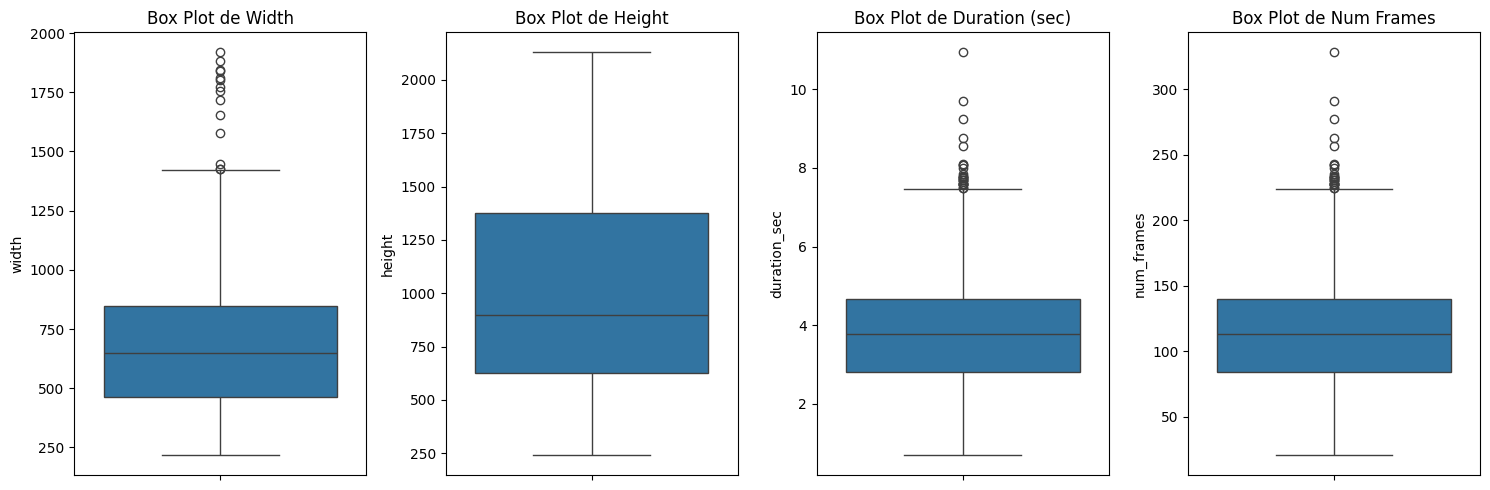

In [12]:
# Para ver as estatísticas das colunas numéricas
print("\n--- Estatísticas Descritivas ---")
print(df_sinais_limpo[['width', 'height', 'duration_sec', 'num_frames']].describe())

# Box Plot para identificar outliers
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.boxplot(y=df_sinais_limpo['width'])
plt.title('Box Plot de Width')

plt.subplot(1, 4, 2)
sns.boxplot(y=df_sinais_limpo['height'])
plt.title('Box Plot de Height')

plt.subplot(1, 4, 3)
sns.boxplot(y=df_sinais_limpo['duration_sec'])
plt.title('Box Plot de Duration (sec)')

plt.subplot(1, 4, 4)
sns.boxplot(y=df_sinais_limpo['num_frames'])
plt.title('Box Plot de Num Frames')

plt.tight_layout()
plt.show()

Alguns outliers que aparecem no gráfico podem indicar apenas vídeos com maior largura (fora do padrão), durações mais altas e alguns com maior quantidade de frames

##### **Normalizando**

In [8]:
# Normalizar apenas as colunas de texto que não são nomes de arquivo
# Normalizei 'sinal' e 'interprete', deixando 'file_name' intocada
for column in ['sinal', 'interprete']:
    if column in df_sinais_limpo.columns and df_sinais_limpo[column].dtype == 'object':
        df_sinais_limpo[column] = df_sinais_limpo[column].apply(
            lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii', 'ignore').decode('utf-8')
        )
print("\nDataFrame após normalização das colunas de texto (sinal e interprete):")
df_sinais_limpo.head()


DataFrame após normalização das colunas de texto (sinal e interprete):


,file_name,width,height,duration_sec,num_frames,sinal,interprete
0,Adição_AP_10.json,738,1008,4.533333,136,Adicao,Alexson
1,Adição_AP_1.json,774,1006,4.766667,143,Adicao,Alexson
2,Adição_AP_2.json,760,1002,4.433333,133,Adicao,Alexson
3,Adição_AP_3.json,762,1000,4.933333,148,Adicao,Alexson
4,Adição_AP_4.json,764,1004,4.600000,138,Adicao,Alexson


## **ETAPA 2: PRÉ-PROCESSAMENTO E EXTRAÇÃO DE CARACTERÍSTICAS (ENGENHARIA DE FEATURES)**

### **Criando e analisando um dataframe longo df_keyframes**

Aqui vamos verificar os arquivos json, consultando o csv e confirmando suas existências, depois é feita a extração dos keypoints em cada frame e alocando em um dataframe longo

**Seleção de features / Limpeza de dados / Normalização**
*   Na criação do df_frames foram removidos keypoints com baixa visibilidade (< 50%) e com coordenadas inconsistentes (fora dos limites da imagem)
*   Analise que em alguns valores de x e y tinham valores fora dos padrões da tela, determinando assim outliers, com isso as coordenadas x e y foram normalizadas pela largura e altura do vídeo para garantir a independência da resolução
*   Com base em análises de visibilidade e relevância, foram selecionados apenas os keypoints referentes ao tronco e membros superiores (Ids: 11-22), e a coordenada z foi descartada

In [9]:
print("--- ETAPA 2: Extraindo, limpando e normalizando os keypoints ---")

all_keypoints_list = []
for index, row in df_sinais_limpo.iterrows():
    file_name = row['file_name']
    sinal = row['sinal']
    interprete = row['interprete']
    json_path = os.path.join(json_dir, file_name)

    if not os.path.exists(json_path):
        continue
    with open(json_path, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            continue

    for frame_data in data['frames']:
        for keypoint in frame_data['keypoints']:
            if keypoint['visibility'] >= 0.5:
                all_keypoints_list.append({
                    'file_name': file_name,
                    'sinal': sinal,
                    'interprete': interprete,
                    'id': keypoint['id'],
                    'x': keypoint['x'],
                    'y': keypoint['y'],
                    'z': keypoint['z'],
                    'visibility': keypoint['visibility']
                })

df_keyframes = pd.DataFrame(all_keypoints_list)
print(f"\n1. Extração concluída. Total de keypoints com boa visibilidade: {len(df_keyframes)}")

# --- ETAPA DE LIMPEZA DE COORDENADAS INVÁLIDAS ---
# Juntar as dimensões (width, height) para poder filtrar
df_dims = df_sinais_limpo[['file_name', 'width', 'height']]
df_keyframes = pd.merge(df_keyframes, df_dims, on='file_name', how='left')

# Guardar o número de linhas antes de remover
rows_before = len(df_keyframes)

# Filtrar para manter apenas as linhas onde as coordenadas estão DENTRO dos limites da imagem
df_keyframes = df_keyframes[
    (df_keyframes['x'] <= df_keyframes['width']) &
    (df_keyframes['y'] <= df_keyframes['height']) &
    (df_keyframes['x'] >= 0) &
    (df_keyframes['y'] >= 0)
].copy() # .copy() para evitar SettingWithCopyWarning

rows_after = len(df_keyframes)
rows_removed = rows_before - rows_after
percent_removed = (rows_removed / rows_before) * 100 if rows_before > 0 else 0

print(f"\n2. Limpeza de coordenadas inválidas concluída.")
print(f"   - Foram removidas {rows_removed} linhas com coordenadas fora dos limites da imagem.")
print(f"   - Isso representa {percent_removed:.2f}% dos dados de keypoints.")

# --- ETAPA DE NORMALIZAÇÃO ---
print("\n3. Normalizando as coordenadas X e Y...")
# Executar a normalização (evitar divisão por zero)
df_keyframes['x'] = df_keyframes['x'] / df_keyframes['width'].replace(0, 1)
df_keyframes['y'] = df_keyframes['y'] / df_keyframes['height'].replace(0, 1)

# Remover as colunas de width e height que não são mais necessárias - retirando tambem o z
df_keyframes.drop(columns=['width', 'height', 'z'], inplace=True)

print("   - Normalização concluída!")
display(df_keyframes[['file_name', 'x', 'y']].head())

--- ETAPA 2: Extraindo, limpando e normalizando os keypoints ---

1. Extração concluída. Total de keypoints com boa visibilidade: 7267939

2. Limpeza de coordenadas inválidas concluída.
   - Foram removidas 175352 linhas com coordenadas fora dos limites da imagem.
   - Isso representa 2.41% dos dados de keypoints.

3. Normalizando as coordenadas X e Y...
   - Normalização concluída!


,file_name,x,y
0,Adição_AP_10.json,0.565041,0.181548
1,Adição_AP_10.json,0.600271,0.151786
2,Adição_AP_10.json,0.616531,0.151786
3,Adição_AP_10.json,0.630081,0.152778
4,Adição_AP_10.json,0.542005,0.152778


In [16]:
print("--- Análise de Visibilidade dos Keypoints ---")

# Calcular a visibilidade média para cada ID de keypoint
visibility_stats = df_keyframes.groupby('id')['visibility'].mean().sort_values()

print("Visibilidade Média por ID de Keypoint (do menor para o maior):")
print(visibility_stats)

--- Análise de Visibilidade dos Keypoints ---
Visibilidade Média por ID de Keypoint (do menor para o maior):
id
26    0.689733
25    0.736215
18    0.957097
22    0.958776
20    0.959930
17    0.975865
21    0.976244
19    0.977460
16    0.980635
24    0.987615
15    0.988162
23    0.988457
14    0.996971
13    0.997544
1     0.999987
3     0.999989
2     0.999990
7     0.999992
4     0.999993
6     0.999994
5     0.999995
8     0.999997
0     0.999998
9     0.999999
10    0.999999
12    1.000000
11    1.000000
Name: visibility, dtype: float64


*Aqui acima ja se havia descartado keypoints abaixo de 0.5, mas percebo que os id:25 e 26 tem uma boa queda de visibilidade quando partem do id:24, por fim decidi removê-los*

*Plotando para maior visibilidade da diferença de cada id/keypoint (lembrando: 27 ao 32 foram removidos por estarem abaixo do limite que eu defini de 50% de visibilidade*

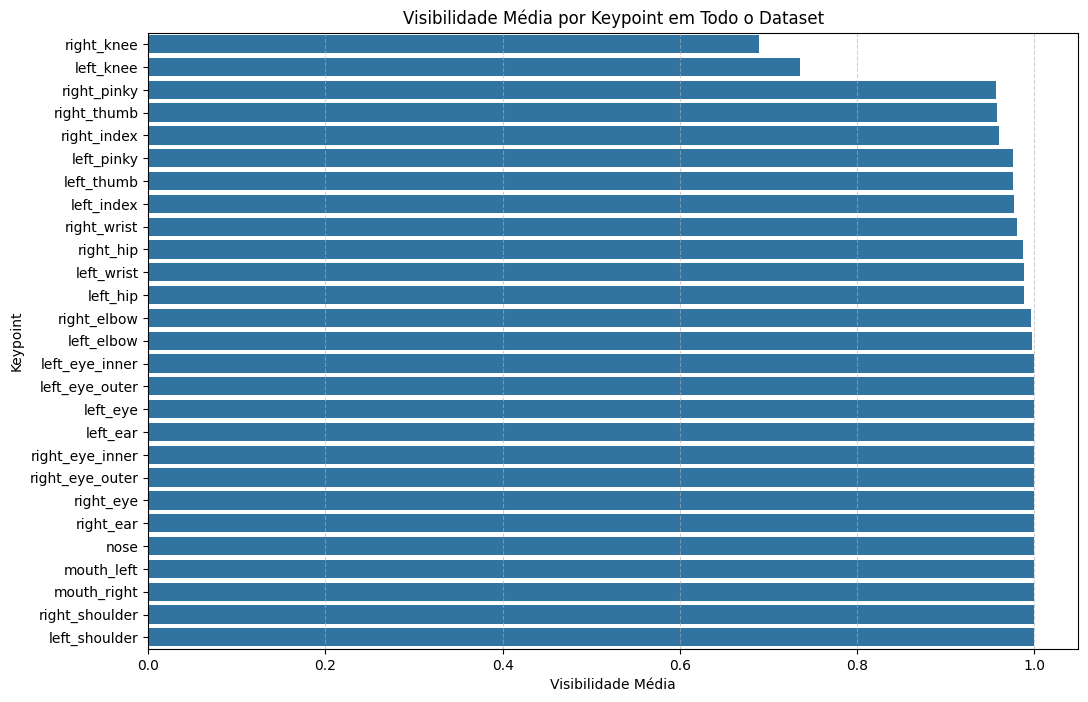

In [17]:
# Dicionário para mapear IDs para nomes de keypoints para melhor interpretação
keypoint_names = {
    0: 'nose', 1: 'left_eye_inner', 2: 'left_eye', 3: 'left_eye_outer',
    4: 'right_eye_inner', 5: 'right_eye', 6: 'right_eye_outer', 7: 'left_ear',
    8: 'right_ear', 9: 'mouth_left', 10: 'mouth_right', 11: 'left_shoulder',
    12: 'right_shoulder', 13: 'left_elbow', 14: 'right_elbow', 15: 'left_wrist',
    16: 'right_wrist', 17: 'left_pinky', 18: 'right_pinky', 19: 'left_index',
    20: 'right_index', 21: 'left_thumb', 22: 'right_thumb', 23: 'left_hip',
    24: 'right_hip', 25: 'left_knee', 26: 'right_knee', 27: 'left_ankle',
    28: 'right_ankle', 29: 'left_heel', 30: 'right_heel', 31: 'left_foot_index',
    32: 'right_foot_index'
}

# Mapear os IDs no índice das estatísticas para nomes
visibility_stats.index = visibility_stats.index.map(keypoint_names)

# Criar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x=visibility_stats.values, y=visibility_stats.index, orient='h')
plt.title('Visibilidade Média por Keypoint em Todo o Dataset')
plt.xlabel('Visibilidade Média')
plt.ylabel('Keypoint')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Analisando o gráfico, tomei a decisão de remover os (id:23,24) por terem uma queda de visibilidade geral, e remover os (id:0-10) por decisão própria e testes feitos sem eles nos modelos, onde decidi manter a análise encima dos padrões de movimento dos keypoints dos membros na região do tronco pra cima, levando assim a melhores resultados.

**Removendo os keypoints escolhidos como menos relevantes**

In [10]:
ids_para_remover = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26] # Foi removido o joelho esquerdo e direito / do 0 ao 10 o rosto / quadril pra baixo

rows_antes = len(df_keyframes)
print(f"Número de registros antes de remover os keypoints de baixa visibilidade: {rows_antes}")

# Remove todas as linhas correspondentes a esses IDs
df_keyframes = df_keyframes[~df_keyframes['id'].isin(ids_para_remover)]

rows_depois = len(df_keyframes)
print(f"Número de registros após a remoção: {rows_depois}")
print(f"Total de {rows_antes - rows_depois} registros removidos.")

Número de registros antes de remover os keypoints de baixa visibilidade: 7092587
Número de registros após a remoção: 3385557
Total de 3707030 registros removidos.


Para o conjunto de ids: 11-22, obtive melhores resultados com diversos testes que fiz, com rosto/sem rosto, com quadril/sem quadril

#### **Analisando a nova base keyframes**

In [19]:
df_keyframes

,file_name,sinal,interprete,id,x,y,visibility
11,Adição_AP_10.json,Adicao,Alexson,11,0.815718,0.382937,1.00
12,Adição_AP_10.json,Adicao,Alexson,12,0.353659,0.377976,1.00
13,Adição_AP_10.json,Adicao,Alexson,13,0.910569,0.633929,1.00
14,Adição_AP_10.json,Adicao,Alexson,14,0.271003,0.630952,1.00
15,Adição_AP_10.json,Adicao,Alexson,15,0.689702,0.775794,0.97
...,...,...,...,...,...,...,...
7267931,Ângulo_TS_9.json,Angulo,Tiago,18,0.071782,0.926045,0.97
7267932,Ângulo_TS_9.json,Angulo,Tiago,19,0.851485,0.916399,0.98
7267933,Ângulo_TS_9.json,Angulo,Tiago,20,0.121287,0.929260,0.97
7267934,Ângulo_TS_9.json,Angulo,Tiago,21,0.836634,0.893891,0.98


--- Análise Estatística do DataFrame 'df_keyframes' ---
                  x             y    visibility
count  3.385557e+06  3.385557e+06  3.385557e+06
mean   5.235902e-01  6.119622e-01  9.808271e-01
std    2.695577e-01  2.210542e-01  3.470709e-02
min    0.000000e+00  6.605691e-02  5.000000e-01
25%    2.616667e-01  3.877551e-01  9.800000e-01
50%    5.275229e-01  5.972222e-01  9.900000e-01
75%    7.865169e-01  8.398148e-01  1.000000e+00
max    9.870968e-01  1.000000e+00  1.000000e+00


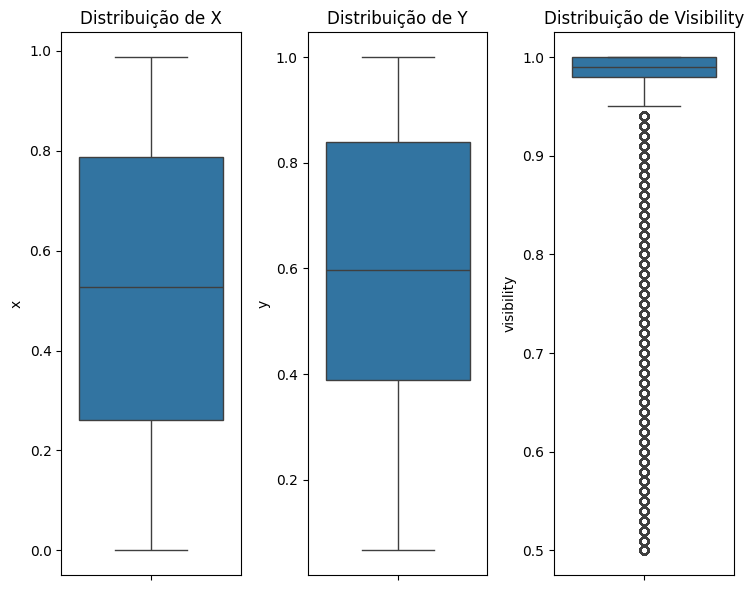

In [20]:
# Analisa as estatísticas descritivas das features de keypoints
print("--- Análise Estatística do DataFrame 'df_keyframes' ---")
print(df_keyframes[['x', 'y', 'visibility']].describe()) # removi z

# Box Plot para identificar a distribuição e outliers globais das coordenadas
plt.figure(figsize=(10, 6))
plt.subplot(1, 4, 1)
sns.boxplot(y=df_keyframes['x'])
plt.title('Distribuição de X')

plt.subplot(1, 4, 2)
sns.boxplot(y=df_keyframes['y'])
plt.title('Distribuição de Y')

# Comentado pois retirei o z e obtive melhor resultado
#plt.subplot(1, 4, 3)
#sns.boxplot(y=df_keyframes['z'])
#plt.title('Distribuição de Z')

plt.subplot(1, 4, 3)
sns.boxplot(y=df_keyframes['visibility'])
plt.title('Distribuição de Visibility')

plt.tight_layout()
plt.show()

### **Criando e analisando um dataframe largo df_features**

**Engenharia de Features**

Os modelos de machine learning clássicos como ( RandomForest, K-NN, MLP) exigem que cada amostra, neste caso cada vídeo, seja representada por um vetor de características de tamanho fixo. Nossos dados brutos (df_keyframes) são sequenciais, com múltiplas linhas por vídeo (uma para cada keypoint em cada frame), e não podem ser usados diretamente por esses algoritmos.

Logo abaixo será feita a transformação dos dados sequenciais em um formato estático e amplo, adequado para o aprendizado de máquina. Para cada vídeo, o código agrupa todos os seus frames e keypoints e calcula um conjunto de estatísticas descritivas (média, desvio padrão, mínimo e máximo) para as coordenadas x e y de cada keypoint selecionado.

Ao final, cada vídeo é representado por uma única linha no novo DataFrame "df_features". As colunas deste DataFrame são as características estatísticas que resumem o movimento completo do sinal, tornando os dados compatíveis com os algoritmos de classificação e clusterização que serão aplicados nas etapas seguintes.

In [11]:
print("Iniciando a agregação de features...")

# Agrupa por 'file_name' para processar cada vídeo individualmente
grouped = df_keyframes.groupby('file_name')

# Lista para armazenar os dados agregados de cada vídeo
feature_list = []

# Itera sobre cada grupo (cada vídeo)
for file_name, group in grouped:
    # Dicionário para armazenar as features deste vídeo
    video_features = {'file_name': file_name}

    # Extrai o rótulo sinal e o intérprete do primeiro registro do grupo já que são os mesmos para todo o vídeo
    video_features['sinal'] = group['sinal'].iloc[0]
    video_features['interprete'] = group['interprete'].iloc[0]

    # Itera sobre cada um dos 12 keypoints selecionados como principais para relevância no treinamento
    for kp_id in range(11,23):
        # Filtra os dados apenas para o keypoint atual
        keypoint_data = group[group['id'] == kp_id]

        # Calcula estatísticas para cada coordenada (x, y)
        for coord in ['x', 'y']: # removi z, pois obteve melhores resultados
            # Extrai a série de dados para a coordenada
            series = keypoint_data[coord]

            # Calcula média, desvio padrão, min e max
            video_features[f'kp_{kp_id}_{coord}_mean'] = series.mean()
            video_features[f'kp_{kp_id}_{coord}_std'] = series.std()
            video_features[f'kp_{kp_id}_{coord}_min'] = series.min()
            video_features[f'kp_{kp_id}_{coord}_max'] = series.max()

    # Adiciona as features do vídeo na lista
    feature_list.append(video_features)

# Cria o DataFrame final com as features agregadas
df_features = pd.DataFrame(feature_list)

# Preenchendo possíveis valores NaN (caso um keypoint não apareça ou não tenha variação)
# O desvio padrão de um único ponto é NaN, então será preenchido com 0.
df_features.fillna(0, inplace=True)

print("DataFrame de features criado com sucesso!")
print(f"Formato do DataFrame: {df_features.shape}")
print("Exemplo do DataFrame final:")
df_features.head()

Iniciando a agregação de features...
DataFrame de features criado com sucesso!
Formato do DataFrame: (2501, 99)
Exemplo do DataFrame final:


,file_name,sinal,interprete,kp_11_x_mean,kp_11_x_std,kp_11_x_min,kp_11_x_max,kp_11_y_mean,kp_11_y_std,kp_11_y_min,...,kp_21_y_min,kp_21_y_max,kp_22_x_mean,kp_22_x_std,kp_22_x_min,kp_22_x_max,kp_22_y_mean,kp_22_y_std,kp_22_y_min,kp_22_y_max
0,Adição_AP_1.json,Adicao,Alexson,0.808505,0.003059,0.803618,0.813953,0.379868,0.003320,0.372763,...,0.401590,0.816103,0.528848,0.072657,0.394057,0.593023,0.669827,0.200893,0.323062,0.830020
1,Adição_AP_10.json,Adicao,Alexson,0.814154,0.003404,0.808943,0.822493,0.378144,0.004525,0.369048,...,0.390873,0.807540,0.501016,0.078129,0.367209,0.577236,0.634155,0.199566,0.329365,0.811508
2,Adição_AP_2.json,Adicao,Alexson,0.815028,0.003260,0.810526,0.823684,0.375820,0.005860,0.365269,...,0.392216,0.797405,0.509794,0.079549,0.386842,0.588158,0.628487,0.208276,0.313373,0.801397
3,Adição_AP_3.json,Adicao,Alexson,0.819838,0.002643,0.817585,0.829396,0.376912,0.003524,0.372000,...,0.415000,0.799000,0.520935,0.079207,0.389764,0.590551,0.644959,0.198138,0.351000,0.805000
4,Adição_AP_4.json,Adicao,Alexson,0.814563,0.003635,0.808901,0.824607,0.377353,0.005651,0.368526,...,0.394422,0.808765,0.523086,0.076078,0.387435,0.589005,0.642712,0.208009,0.324701,0.809761


12 ids(11-22), 4 métricas(mean,std,min,max), 2 coordenadas(x,y)= 96 colunas pra treino

**Análise de Balanceamento de Classes (Reavaliação)**


--- Contagem de Classes (Sinais) no DataFrame de Features ---
sinal
Adicao              101
Aluno               101
Antropologia        100
Apontador           100
Apostila            100
Biologia            100
Capitulo            100
Classe              100
Coerencia           100
Ensinar             100
Coesao              100
Colega              100
Conceito            100
Contexto            100
Curso               100
Dicionario          100
Disciplina          100
Fisica              100
Escola              100
Estudar             100
Filosofia           100
Historia            100
Geografia           100
Angulo              100
Bolsa de Estudos     99
Name: count, dtype: int64


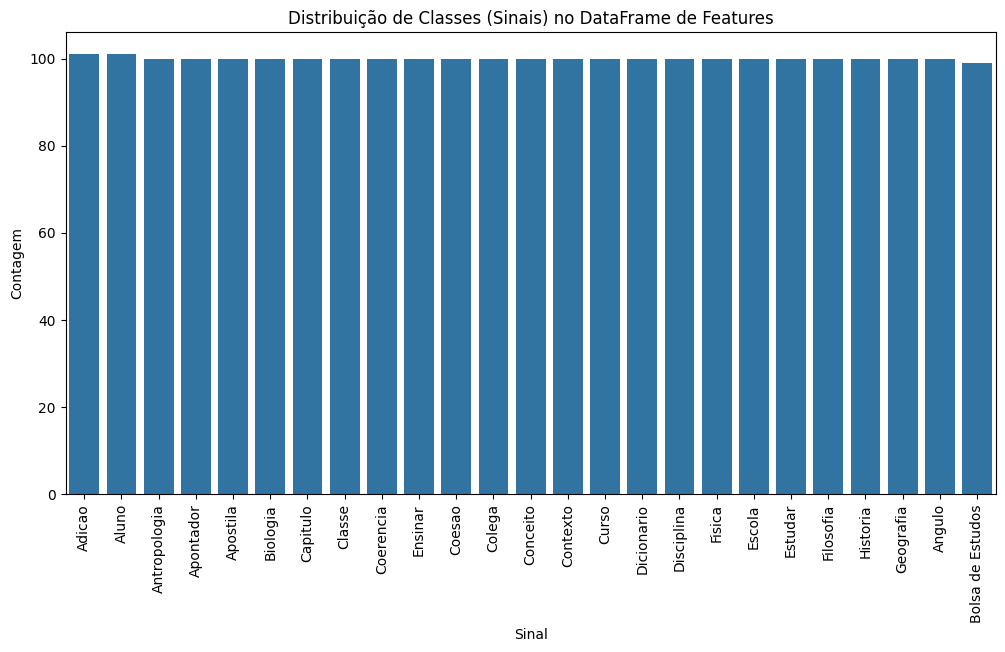

In [22]:
# Contagem de exemplos por sinal na base final de features
print("\n--- Contagem de Classes (Sinais) no DataFrame de Features ---")
class_counts = df_features['sinal'].value_counts()
print(class_counts)

# Visualização da distribuição das classes
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribuição de Classes (Sinais) no DataFrame de Features')
plt.xlabel('Sinal')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

**Análise de Correlação das Features Agregadas**

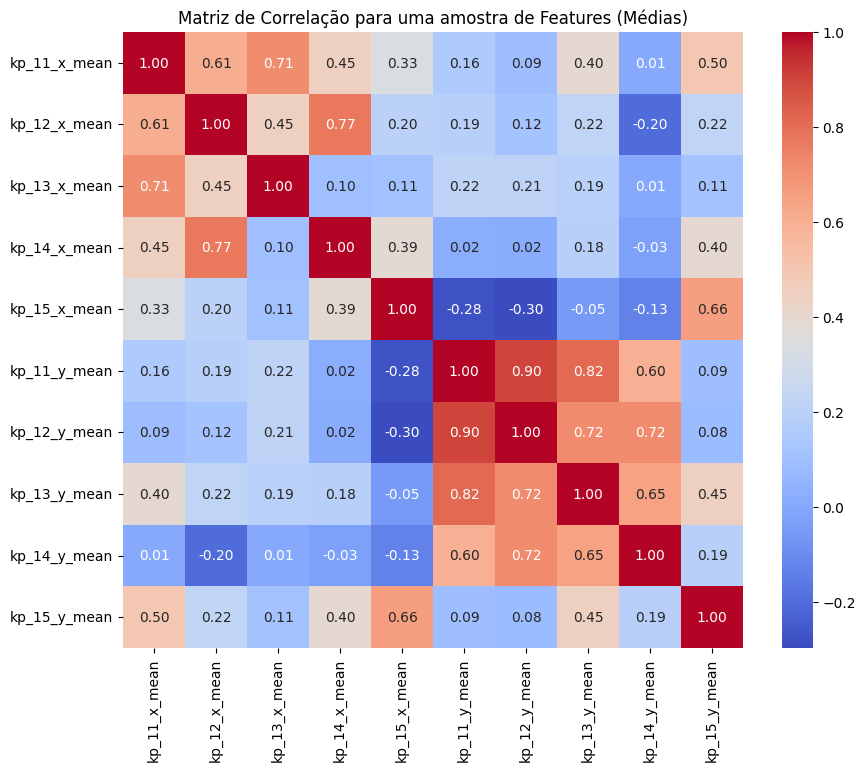

In [23]:
# Selecionando uma amostra de features para a matriz de correlação para evitar um gráfico muito grande
# Aqui foram pegas as médias para os primeiros keypoints
sample_features = [f'kp_{i}_x_mean' for i in range(11,16)] + [f'kp_{i}_y_mean' for i in range(11,16)]
sample_features_df = df_features[sample_features]

correlation_matrix = sample_features_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação para uma amostra de Features (Médias)')
plt.show()

## **ETAPA 3: PREPARAÇÃO, TREINAMENTO E AVALIAÇÃO (APLICANDO ONEHOTENCODE NA COLUNA DE INTERPRETE)**

Nos testes que foram realizados, foi observado que a aplicação da Análise de Componentes Principais (PCA) para reduzir a dimensionalidade antes da classificação resultou em uma queda na performance dos modelos. Isso ocorre porque o PCA é projetado para maximizar a variância dos dados, e não necessariamente a informação que melhor distingue as classes. No processo de redução, o PCA acabou descartando componentes de baixa variância que, apesar de sutis, continham detalhes de movimento essenciais para diferenciar sinais muito parecidos entre si. Por essa razão, concluiu-se que o conjunto completo de features engenheiradas era mais informativo para o treinamento, limitando o uso do PCA apenas à tarefa de visualização 2D dos clusters, onde se mostrou uma ferramenta eficaz.

### **Preparando os dados para o modelo (Separação de dados / Codificação de Rótulos / Padronização de Features)**

**DIVISÃO POR INTÉRPRETES (70/30)**

*Utilizando de 70% da base para o treinamento e 30% para a validação, onde serão dos 10 interpretes: 7 para treinamento e 3 para o teste final para que o modelo não os tenha visto no treinamento*

In [12]:
# Obtem a lista de todos os interpretes únicos
all_interpreters = df_features['interprete'].unique()
np.random.seed(random_state) # Usar o mesmo random_state para garantir que a divisão seja sempre a mesma
np.random.shuffle(all_interpreters) # Embaralhar a lista de intérpretes

# Separa os interpretes para treino e para teste
# Total de interpretes: 10
# Usarei 30% de 10, então vou separar 3 para teste e 7 para treino
num_test_interpreters = 3
test_interpreters = all_interpreters[:num_test_interpreters]
train_interpreters = all_interpreters[num_test_interpreters:]

print("Divisão por Intérpretes:")
print(f"Intérpretes de TREINO ({len(train_interpreters)}): {list(train_interpreters)}")
print(f"Intérpretes de TESTE ({len(test_interpreters)}): {list(test_interpreters)}")

# Criando os DataFrames de treino e teste final com base nos interpretes
train_df = df_features[df_features['interprete'].isin(train_interpreters)]
final_test_df = df_features[df_features['interprete'].isin(test_interpreters)]

# Separação de X e y para os dois conjuntos
X_main_train = train_df.drop(columns=['file_name', 'sinal'])
y_main_train_labels = train_df['sinal']

X_final_test = final_test_df.drop(columns=['file_name', 'sinal'])
y_final_test_labels = final_test_df['sinal']

# Codificando os rótulos (y) para o formato numérico
le = LabelEncoder()
y_main_train = le.fit_transform(y_main_train_labels)
y_final_test = le.transform(y_final_test_labels)

print(f"\nDados divididos em:")
print(f" - Conjunto de Treino/Validação: {X_main_train.shape[0]} amostras")
print(f" - Conjunto de Teste Final: {X_final_test.shape[0]} amostras")

categorical_features = ['interprete']
numerical_features = X_main_train.columns.drop(categorical_features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Divisão por Intérpretes:
Intérpretes de TREINO (7): ['Alexson', 'Rosenice', 'Dannubia', 'Luana', 'Everton', 'Dilainne', 'Aparecida']
Intérpretes de TESTE (3): ['Tiago', 'Cecilia', 'Jackeline']

Dados divididos em:
 - Conjunto de Treino/Validação: 1751 amostras
 - Conjunto de Teste Final: 750 amostras


Divisão por Intérpretes:

Intérpretes de TREINO (7): ['Alexson', 'Rosenice', 'Dannubia', 'Luana', 'Everton', 'Dilainne', 'Aparecida']

Intérpretes de TESTE (3): ['Tiago', 'Cecilia', 'Jackeline']

Dados divididos em:

 - Conjunto de Treino/Validação: 1751 amostras

 - Conjunto de Teste Final: 750 amostras

### **BUSCA DE MELHORES PARÂMETROS PARA OS MODELOS**

#### *RODADAS DE GRIDSEARCH PARA OBTER MELHORES PARAMETROS*

**GridSearch em KNN**

In [27]:
# Cria um Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15], # Mais valores de K para testar
    'model__weights': ['uniform', 'distance'],      # Opções de pesos
    'model__metric': ['euclidean', 'manhattan', 'minkowski'] # Opções de métrica de distância
}

# Cria e treina o objeto GridSearchCV
knn_grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

print("--- Iniciando a busca pelos melhores parâmetros para o K-NN ---")
knn_grid_search.fit(X_main_train, y_main_train)

# Exibe os melhores resultados encontrados
print("\n--- Resultados do GridSearchCV para K-NN ---")
print(f"Melhor pontuação (F1-score na validação): {knn_grid_search.best_score_:.4f}")
print(f"Melhores hiperparâmetros: {knn_grid_search.best_params_}")

best_knn_model = knn_grid_search.best_estimator_

--- Iniciando a busca pelos melhores parâmetros para o K-NN ---
Fitting 5 folds for each of 42 candidates, totalling 210 fits

--- Resultados do GridSearchCV para K-NN ---
Melhor pontuação (F1-score na validação): 0.9886
Melhores hiperparâmetros: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'uniform'}


Fitting 5 folds for each of 42 candidates, totalling 210 fits

**--- Resultados do GridSearchCV para K-NN ---**

Melhor pontuação (F1-score na validação): 0.9886
Melhores hiperparâmetros: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'uniform'}

**GridSearch em RandomForest**

In [28]:
# Otimização de Hiperparâmetros para RandomForest com GridSearchCV

# Criando um Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=random_state))
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 3, 4],
    'model__max_features': ['sqrt', 'log2']
}

# Criando e treinando o GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

print("--- Iniciando a busca pelos melhores parâmetros para o RandomForest ---")
rf_grid_search.fit(X_main_train, y_main_train)

# Exibe os melhores resultados
print("\n--- Resultados do GridSearchCV para RandomForest ---")
print(f"Melhor pontuação (F1-score na validação): {rf_grid_search.best_score_:.4f}")
print(f"Melhores hiperparâmetros: {rf_grid_search.best_params_}")

best_rf_model = rf_grid_search.best_estimator_

--- Iniciando a busca pelos melhores parâmetros para o RandomForest ---
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

--- Resultados do GridSearchCV para RandomForest ---
Melhor pontuação (F1-score na validação): 0.9880
Melhores hiperparâmetros: {'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}


Fitting 5 folds for each of 288 candidates, totalling 1440 fits

**--- Resultados do GridSearchCV para RandomForest ---**

Melhor pontuação (F1-score na validação): 0.9880
Melhores hiperparâmetros: {'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}

**GridSearch em MLP**

In [29]:
# Otimização de Hiperparâmetros para MLP com GridSearchCV

# Criando um Pipeline
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPClassifier(random_state=random_state, max_iter=1000))
])

param_grid_mlp = {
    'model__hidden_layer_sizes': [(50,), (100,), (150,), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam', 'sgd'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate': ['constant', 'adaptive']
}

# Criar e treinar o GridSearchCV
mlp_grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid_mlp,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

print("--- Iniciando a busca pelos melhores parâmetros para o MLP ---")
mlp_grid_search.fit(X_main_train, y_main_train)

# Exibe os melhores resultados
print("\n--- Resultados do GridSearchCV para MLP ---")
print(f"Melhor pontuação (F1-score na validação): {mlp_grid_search.best_score_:.4f}")
print(f"Melhores hiperparâmetros: {mlp_grid_search.best_params_}")

best_mlp_model = mlp_grid_search.best_estimator_

--- Iniciando a busca pelos melhores parâmetros para o MLP ---
Fitting 5 folds for each of 96 candidates, totalling 480 fits

--- Resultados do GridSearchCV para MLP ---
Melhor pontuação (F1-score na validação): 0.9804
Melhores hiperparâmetros: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate': 'constant', 'model__solver': 'adam'}


Fitting 5 folds for each of 96 candidates, totalling 480 fits

**--- Resultados do GridSearchCV para MLP ---**

Melhor pontuação (F1-score na validação): 0.9804
Melhores hiperparâmetros: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate': 'constant', 'model__solver': 'adam'}

#### *TESTE 2 - PARAMETROS SUGERIDOS PELO GDCV*

In [43]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

models = {
    'RandomForest': RandomForestClassifier(
        # Parâmetros otimizados pelo GridSearchCV
        n_estimators=300,
        max_depth=30,
        max_features='log2',
        min_samples_leaf=1,
        min_samples_split=2,
        random_state=random_state
    ),
    'K-NN': KNeighborsClassifier(
        # Parâmetros otimizados pelo GridSearchCV
        n_neighbors=3,
        metric='minkowski', # "manhattan" foi dado pelo grid, mas testei com minkowski e obtive melhora
        weights='uniform'
    ),
    'MLP': MLPClassifier(
        # Parâmetros otimizados pelo GridSearchCV:
        hidden_layer_sizes=(100,), # grid (100, 50)
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate='constant',
        max_iter=300, # grid 400
        random_state=random_state
    )
}
# ==============================================================================

results = {model_name: {'f1_scores': [], 'confusion_matrices': []} for model_name in models}

print("Dicionário 'models' atualizado com os melhores hiperparâmetros encontrados.")

Dicionário 'models' atualizado com os melhores hiperparâmetros encontrados.


**RESULTADOS DOS MODELOS ANTES E APÓS O GridSearch:**

-------
-------

**Antes do GridSearch - testes iniciais:**

--- F1-Score Final para RandomForest: 0.4399 ---


------

--- F1-Score Final para K-NN: 0.2139 ---


------


--- F1-Score Final para MLP: 0.3515 ---



------
------

**Após usar GridSearch:**

**(DEFINITIVO)** ==  F1-Score Final para RandomForest: 0.5154  --- **MELHOR**

-------

**(DEFINITIVO)** == F1-Score Final para K-NN: 0.4137   --- **MELHOR**

--------

**(DEFINITIVO)** == F1-Score Final para MLP: 0.5871   --- **MELHOR**

-------
-------

### **TREINAMENTO COM VALIDAÇÃO CRUZADA ESTRATIFICADA**

* Para garantir uma avaliação robusta e realista da capacidade de generalização do modelo, foi adotada uma metodologia de divisão de dados em duas etapas, em vez de usar diretamente o StratifiedGroupKFold. O objetivo principal era simular um cenário real, onde o modelo é treinado com um grupo de usuários (intérpretes) e depois testado em um grupo de novos usuários nunca vistos antes.

Em vez de usar o StratifiedGroupKFold, usarei o StratifiedKfold pois obtive melhores resultados com ele partindo da decisão de modelar a base no formato 70/30*

In [44]:
prediction_details = []

# --- LOOP DE VALIDAÇÃO CRUZADA ---
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_main_train, y_main_train)):
    print(f"\n--- Processando Fold {fold_idx + 1}/{n_splits} ---")

    # Divide os dados ANTES de qualquer pré-processamento
    X_train_fold, X_val_fold = X_main_train.iloc[train_index], X_main_train.iloc[test_index]
    y_train_fold, y_val_fold = y_main_train[train_index], y_main_train[test_index]

    # Ajusta o pré-processador (scaler + one-hot-encoder) APENAS nos dados de TREINO
    X_train_processed = preprocessor.fit_transform(X_train_fold)

    # APENAS TRANSFORMAR os dados de TESTE com o pré-processador já ajustado
    X_val_processed = preprocessor.transform(X_val_fold)

    for model_name, model in models.items():
        print(f"Treinando {model_name}...")
        # Treina com os dados de treino totalmente processados
        model.fit(X_train_processed, y_train_fold)

        # Prever com os dados de teste totalmente processados
        y_pred = model.predict(X_val_processed)

        # Calcula e armazena as métricas
        f1 = f1_score(y_val_fold, y_pred, average='weighted')
        cm = confusion_matrix(y_val_fold, y_pred, labels=le.transform(le.classes_))
        results[model_name]['f1_scores'].append(f1)
        results[model_name]['confusion_matrices'].append(cm)

        # --- Salva detalhes da previsão ---
        for i in range(len(y_val_fold)):
            # Obtem o indice original do DataFrame df_features
            original_idx = X_main_train.iloc[test_index[i]].name
            true_label = le.inverse_transform([y_val_fold[i]])[0]
            predicted_label = le.inverse_transform([y_pred[i]])[0]

            prediction_details.append({
                'fold': fold_idx + 1,
                'model': model_name,
                'file_name': df_features.loc[original_idx, 'file_name'],
                'true_label': true_label,
                'predicted_label': predicted_label,
                'is_correct': true_label == predicted_label
            })

print("\nValidação cruzada concluída!")


--- Processando Fold 1/5 ---
Treinando RandomForest...
Treinando K-NN...
Treinando MLP...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



--- Processando Fold 2/5 ---
Treinando RandomForest...
Treinando K-NN...
Treinando MLP...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



--- Processando Fold 3/5 ---
Treinando RandomForest...
Treinando K-NN...
Treinando MLP...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



--- Processando Fold 4/5 ---
Treinando RandomForest...
Treinando K-NN...
Treinando MLP...

--- Processando Fold 5/5 ---
Treinando RandomForest...
Treinando K-NN...
Treinando MLP...

Validação cruzada concluída!


Para os fols(1,2,3) ao treinar o MLP saiu esse alerta: */usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.warnings.warn(*

Pois com 300 iterações ele não foi até dava pra ir de aprendizado, mas mesmo com isso houve uma melhora no teste final, onde o algoritmo aprendeu os dados e não os "decorou" com muitas iterações. (400 não aparece este alerta, mas também baixa a performance no teste final para dados nuncas vistos)

Manter as iterações sem extrapolação é um bom método também para evitar overfitting.

### **ANÁLISE DE ERROS E AVALIAÇÃO PARA O DESEMPENHO DA VALIDAÇÃO CRUZADA**

#### **Criando um DataFrame de Análise e Filtrando os Erros**

In [45]:
# Cria um DataFrame com os detalhes das previsões para facilitar a análise
df_analysis = pd.DataFrame(prediction_details)

In [46]:
print("--- DataFrame de Análise de Previsões ---")
print(f"Total de previsões analisadas: {len(df_analysis)}")
display(df_analysis.head())


# Filtra apenas as previsões incorretas
df_errors = df_analysis[df_analysis['is_correct'] == False]

print("\n--- Tabela de Erros dos Modelos ---")
print(f"Total de erros encontrados: {len(df_errors)}")
# Mostra os 15 primeiros erros encontrados
display(df_errors.head(15))

--- DataFrame de Análise de Previsões ---
Total de previsões analisadas: 5253


,fold,model,file_name,true_label,predicted_label,is_correct
0,1,RandomForest,Adição_AP_10.json,Adicao,Adicao,True
1,1,RandomForest,Adição_AP_3.json,Adicao,Adicao,True
2,1,RandomForest,Adição_AP_6.json,Adicao,Adicao,True
3,1,RandomForest,Adição_AP_9.json,Adicao,Adicao,True
4,1,RandomForest,Adição_Dannubia_10.json,Adicao,Adicao,True



--- Tabela de Erros dos Modelos ---
Total de erros encontrados: 96


,fold,model,file_name,true_label,predicted_label,is_correct
168,1,RandomForest,Conceito_Dannubia_2.json,Conceito,Capitulo,False
205,1,RandomForest,Curso_MA_8.json,Curso,Estudar,False
216,1,RandomForest,Dicionário_EL_1.json,Dicionario,Estudar,False
302,1,RandomForest,Física_LS_10.json,Fisica,Historia,False
325,1,RandomForest,História_Dannubia_9.json,Historia,Geografia,False
473,1,K-NN,Classe_RL_1.json,Classe,Coerencia,False
552,1,K-NN,Curso_MA_1.json,Curso,Estudar,False
556,1,K-NN,Curso_MA_8.json,Curso,Estudar,False
611,1,K-NN,Escola_LS_1.json,Escola,Conceito,False
659,1,K-NN,Geografia_Dannubia_2.json,Geografia,Historia,False




**Total de previsões analisadas: 5253**

**COM PARAMETROS GRIDSEARCH:**

SEM Z/SEM ROSTO/QUADRIL/PERNAS == Total de erros encontrados: 96

**SEM PARAMETROS GRIDSEARCH:**

Total de erros encontrados, sem rosto e quadril pra baixo: 97

SEM Z - SEM CONSIDERAR ROSTO - Total de erros encontrados: 111

SEM Z - SEM CONSIDERAR ROSTO/QUADRIL - Total de erros encontrados: 117

#### **Métricas para Avaliação**

Resultados de Classificação:
Modelo: RandomForest
  Média F1-score (ponderada): 0.9880
  Matriz de Confusão (Exemplo de um Fold):


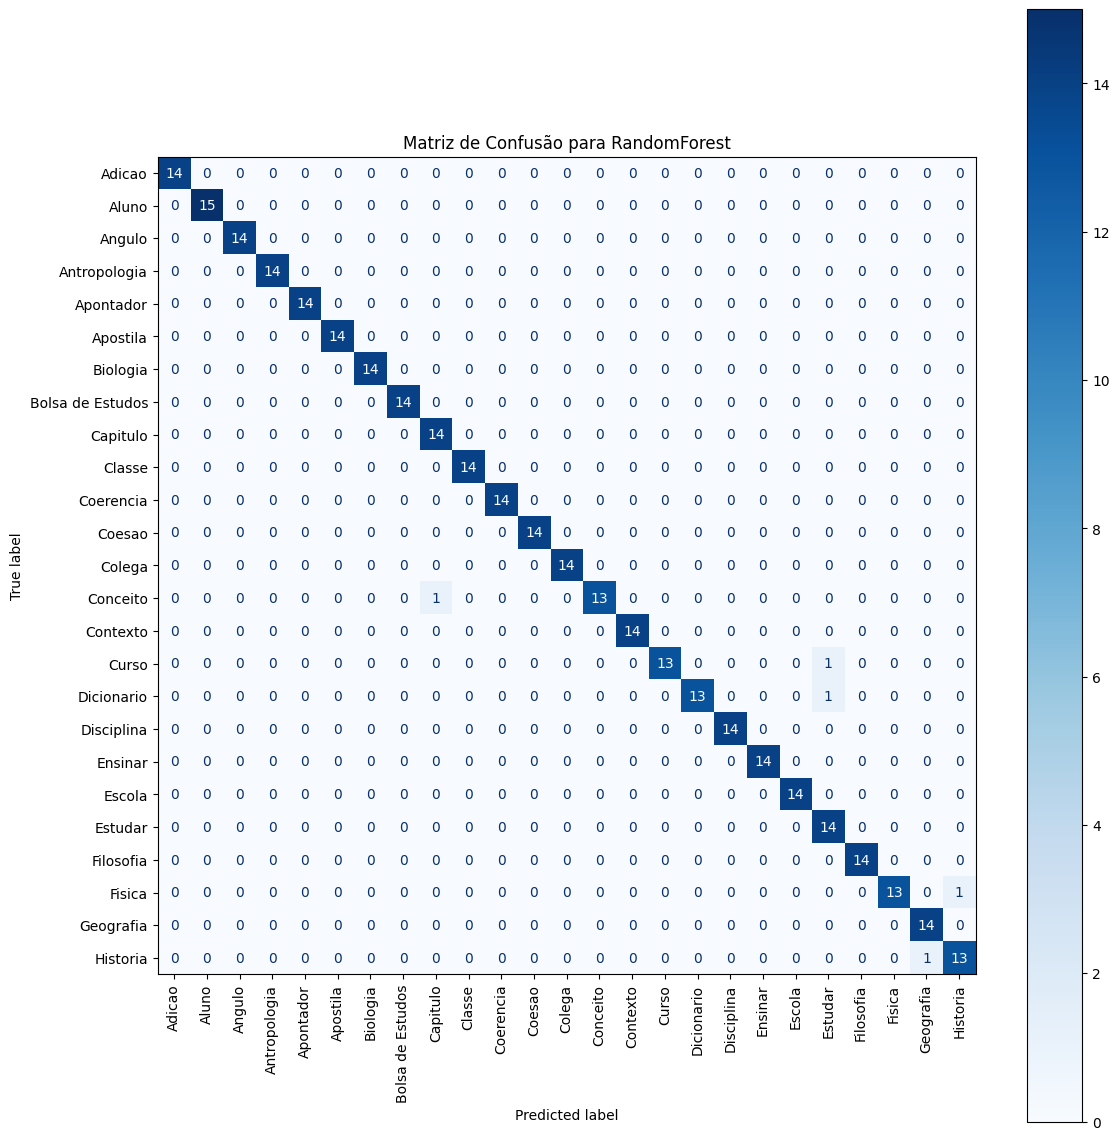

Modelo: K-NN
  Média F1-score (ponderada): 0.9846
  Matriz de Confusão (Exemplo de um Fold):


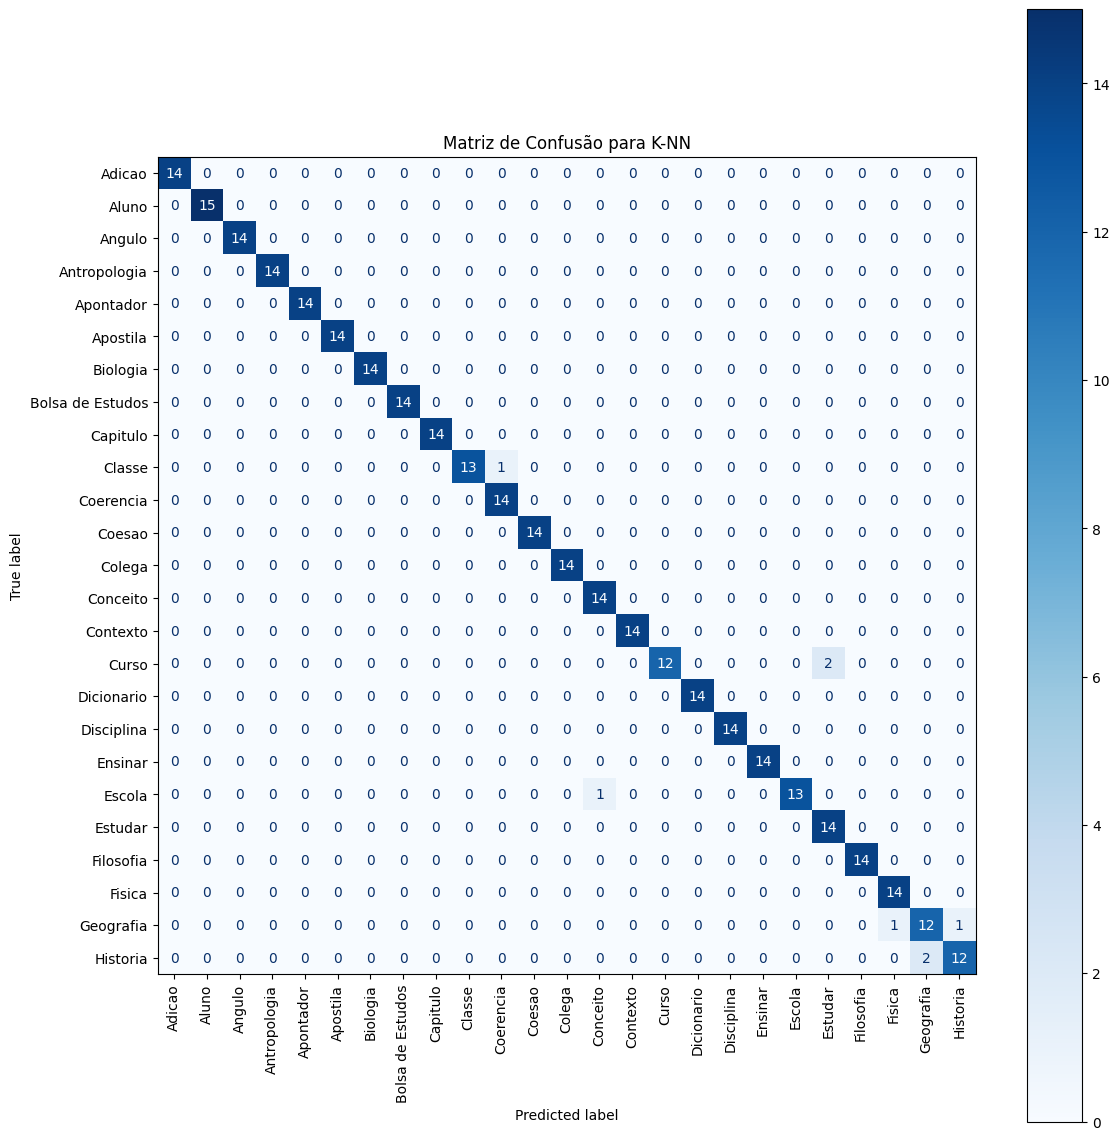

Modelo: MLP
  Média F1-score (ponderada): 0.9723
  Matriz de Confusão (Exemplo de um Fold):


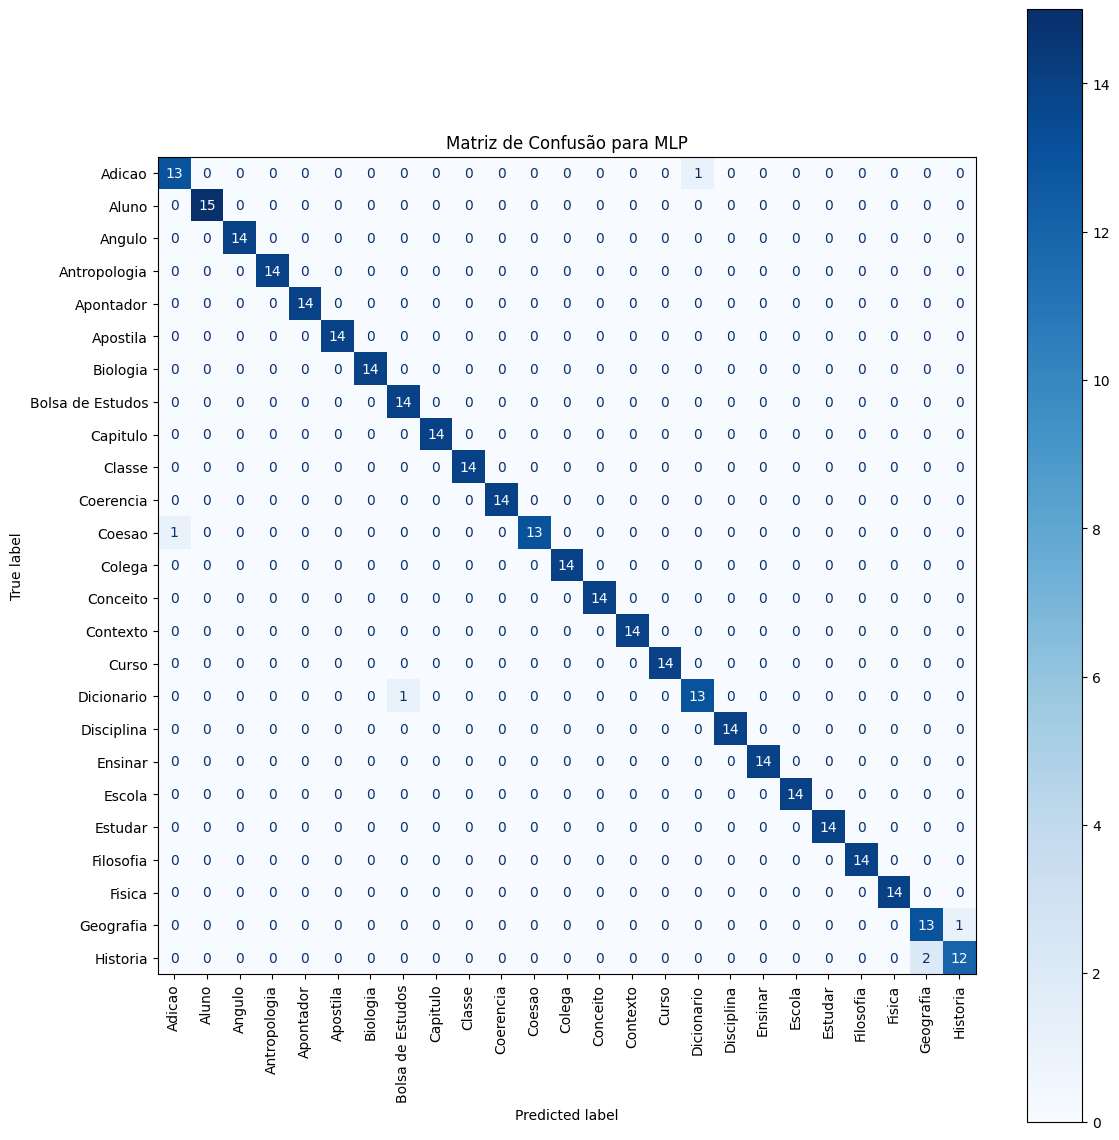

In [47]:
# Exibe os resultados médios de F1-score e a matriz de confusão de um dos folds
print("Resultados de Classificação:")

for model_name, res in results.items():
    avg_f1 = np.mean(res['f1_scores'])
    print(f"Modelo: {model_name}")
    print(f"  Média F1-score (ponderada): {avg_f1:.4f}")

    # Exibe uma das matrizes de confusão
    print(f"  Matriz de Confusão (Exemplo de um Fold):")

    # Uso de le.classes_ para mostrar os nomes dos sinais
    disp = ConfusionMatrixDisplay(confusion_matrix=res['confusion_matrices'][0],
                                  display_labels=le.classes_)

    # Plotando
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title(f"Matriz de Confusão para {model_name}")
    plt.tight_layout()
    plt.show()


***SCORE DE PERFOMANCE NO TREINAMENTO***

*- ANTES DO GRID*

Modelo: RandomForest
  Média F1-score (ponderada): 0.9851

Modelo: K-NN
  Média F1-score (ponderada): 0.9788

Modelo: MLP
  Média F1-score (ponderada): 0.9723 - 300 iterações / 0.9687 - 400 iterações

*- DEPOIS DO GRID*

Modelo: RandomForest
  Média F1-score (ponderada): 0.9880

Modelo: K-NN
  Média F1-score (ponderada): 0.9846

Modelo: MLP
  Média F1-score (ponderada): 0.9723


### **TREINO E TESTE FINAL PARA OS 3 MODELOS**

--- INICIANDO AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---
Ajustando pré-processador em todo o conjunto de treino (1751 amostras)...
Pré-processamento dos conjuntos de treino e teste final concluído.

==================== AVALIANDO: RandomForest ====================
Treinando RandomForest...
Fazendo previsões com RandomForest no conjunto de teste final...

--- F1-Score Final para RandomForest: 0.5154 ---

--- Matriz de Confusão Final para RandomForest ---


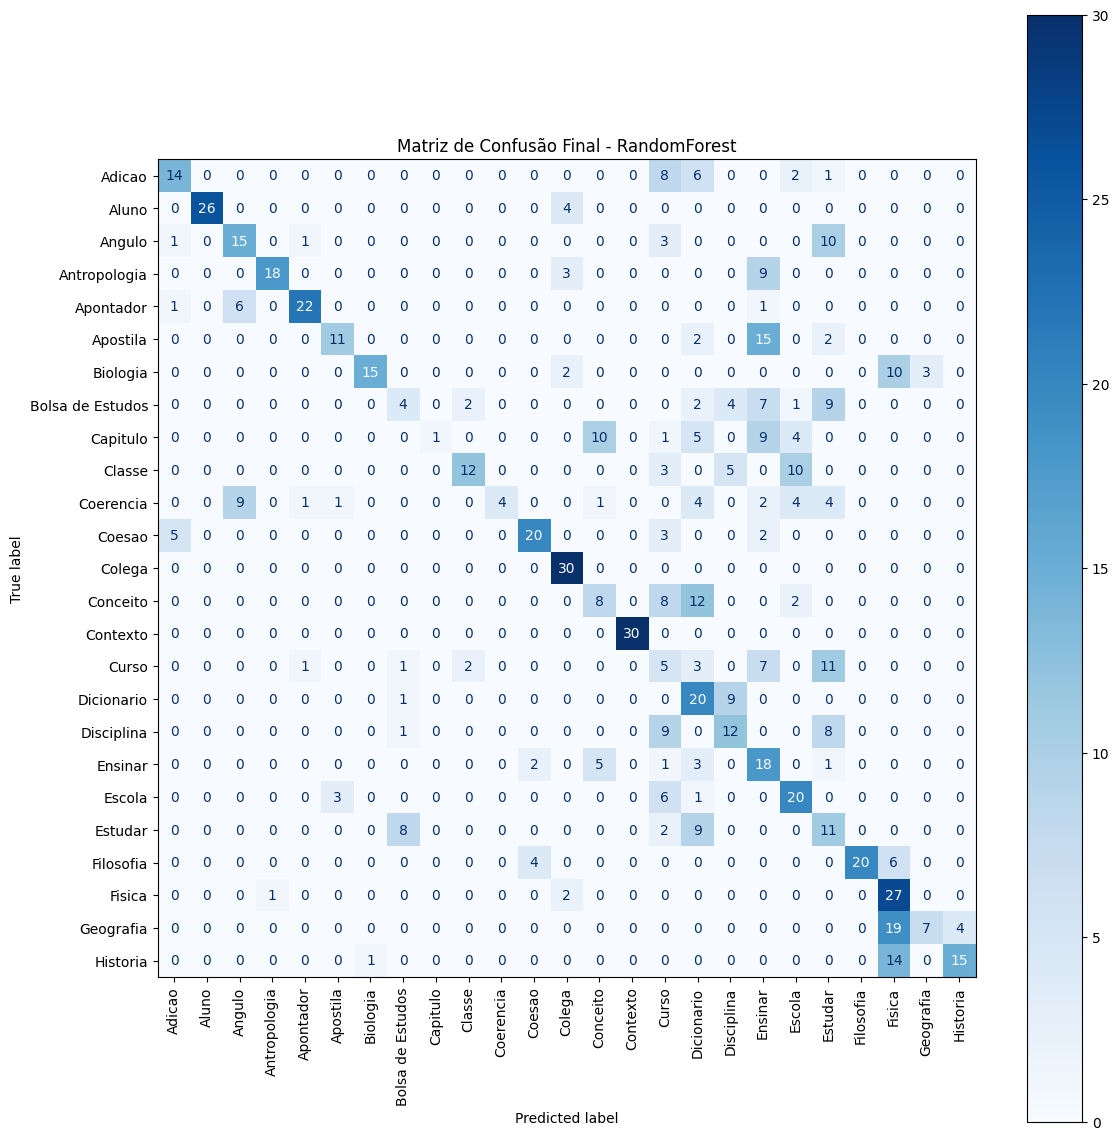


==================== AVALIANDO: K-NN ====================
Treinando K-NN...
Fazendo previsões com K-NN no conjunto de teste final...

--- F1-Score Final para K-NN: 0.4137 ---

--- Matriz de Confusão Final para K-NN ---


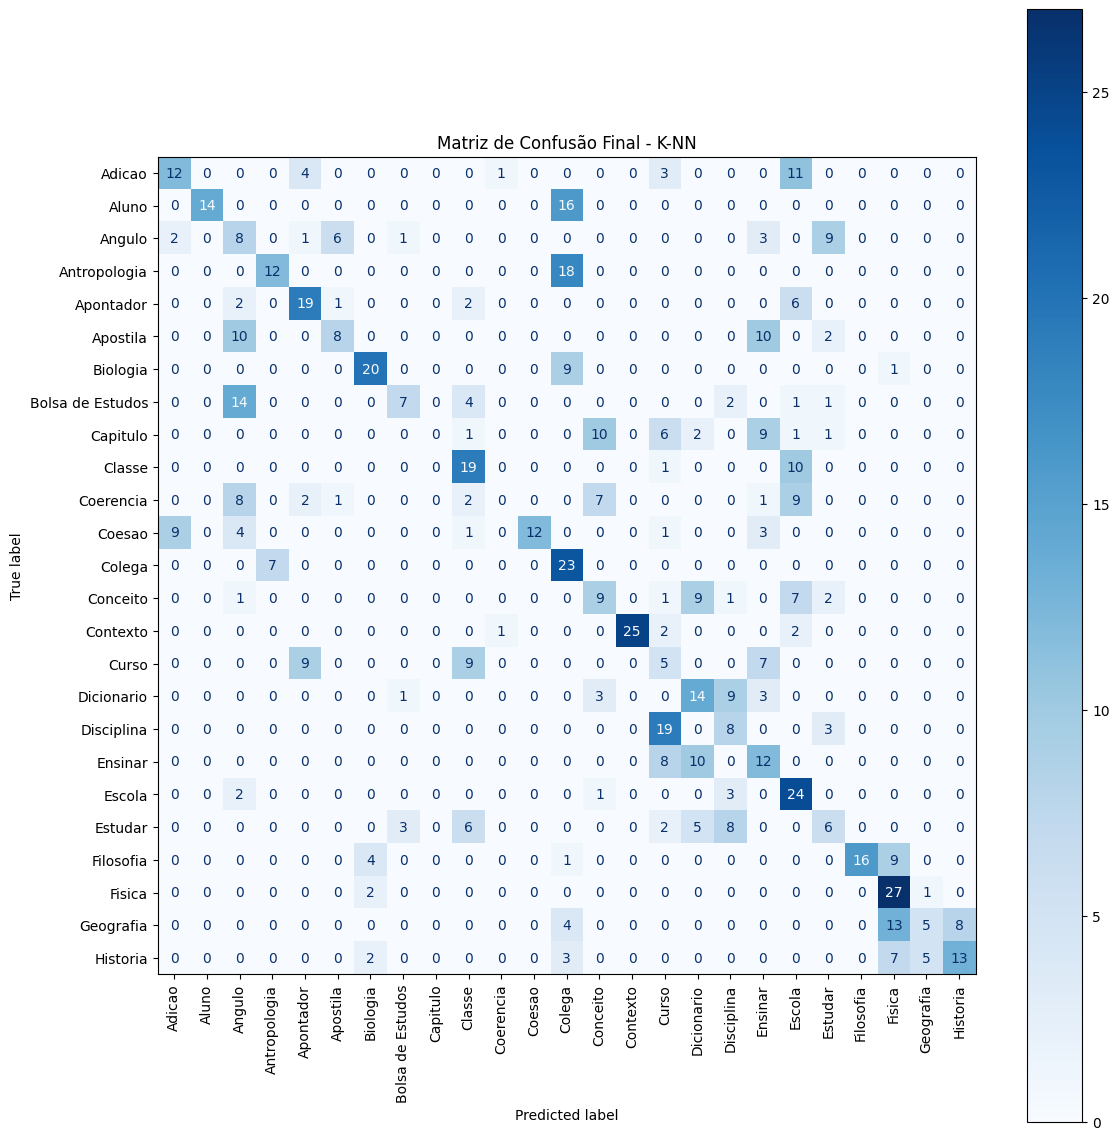


==================== AVALIANDO: MLP ====================
Treinando MLP...
Fazendo previsões com MLP no conjunto de teste final...

--- F1-Score Final para MLP: 0.5871 ---

--- Matriz de Confusão Final para MLP ---


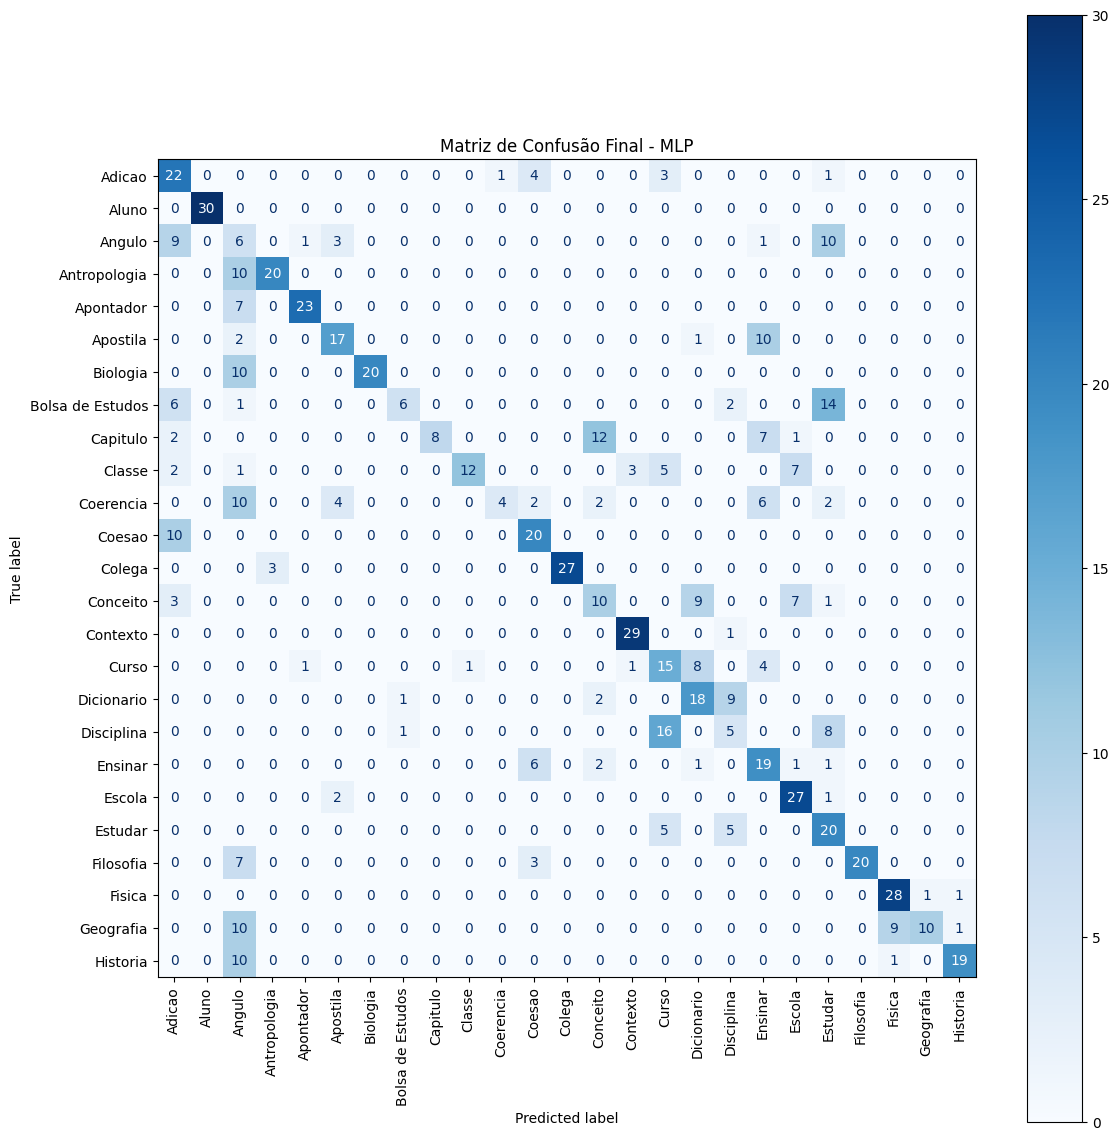

In [48]:
print("--- INICIANDO AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---")

# 1. Ajusta o pré-processador em TODOS os dados de treino (80% do total)
#    Isso prepara o preprocessor para ser usado nos dados de teste.
print(f"Ajustando pré-processador em todo o conjunto de treino ({len(X_main_train)} amostras)...")
preprocessor.fit(X_main_train)

# 2. Pré-processa os dois conjuntos (treino principal e teste final)
X_main_train_processed = preprocessor.transform(X_main_train)
X_final_test_processed = preprocessor.transform(X_final_test)

print("Pré-processamento dos conjuntos de treino e teste final concluído.")


# 3. Itera sobre cada modelo para treinar e avaliar
for model_name, model in models.items():
    print(f"\n{'='*20} AVALIANDO: {model_name} {'='*20}")

    # Treina o modelo com TODOS os dados de treino processados
    print(f"Treinando {model_name}...")
    model.fit(X_main_train_processed, y_main_train)

    # Faz previsões no conjunto de teste final processado
    print(f"Fazendo previsões com {model_name} no conjunto de teste final...")
    final_predictions = model.predict(X_final_test_processed)

    # Calcula e exibe o F1-score final
    final_f1_score = f1_score(y_final_test, final_predictions, average='weighted')
    print(f"\n--- F1-Score Final para {model_name}: {final_f1_score:.4f} ---")

    # Plota a matriz de confusão final para o modelo atual
    print(f"\n--- Matriz de Confusão Final para {model_name} ---")
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_final_test,
        final_predictions,
        display_labels=le.classes_,
        cmap=plt.cm.Blues,
        xticks_rotation='vertical',
        ax=ax
    )
    plt.title(f"Matriz de Confusão Final - {model_name}")
    plt.tight_layout()
    plt.show()

In [49]:
# Exibe um relatório completo da Classificação final
print("\n--- Relatório de Classificação Final ---")
print(classification_report(y_final_test, final_predictions, target_names=le.classes_))


--- Relatório de Classificação Final ---
                  precision    recall  f1-score   support

          Adicao       0.41      0.71      0.52        31
           Aluno       1.00      1.00      1.00        30
          Angulo       0.08      0.20      0.12        30
    Antropologia       0.87      0.67      0.75        30
       Apontador       0.92      0.77      0.84        30
        Apostila       0.65      0.57      0.61        30
        Biologia       1.00      0.67      0.80        30
Bolsa de Estudos       0.75      0.21      0.32        29
        Capitulo       1.00      0.27      0.42        30
          Classe       0.92      0.40      0.56        30
       Coerencia       0.80      0.13      0.23        30
          Coesao       0.57      0.67      0.62        30
          Colega       1.00      0.90      0.95        30
        Conceito       0.36      0.33      0.34        30
        Contexto       0.88      0.97      0.92        30
           Curso       0.34  

**RESULTADOS DOS MODELOS ANTES E APÓS O GridSearch considerando e não considerando a coluna Z(distância da câmera):**

* **COM GRIDSEARCH + modificação com teste manual:**
*SEM Z - SEM ROSTO/QUADRIL/PERNAS*

  **(DEFINITIVO)** ==  F1-Score Final para RandomForest: 0.5154  --- **MELHOR**

  -------

  **(DEFINITIVO)** == F1-Score Final para K-NN: 0.4137   --- **MELHOR**

  --------

  **(DEFINITIVO)** == F1-Score Final para MLP: 0.5871   --- **MELHOR**

-------
-------

* **SEM GRIDSEARCH:**

  ***TESTES INICIAIS:***

  --- F1-Score Final para RandomForest: 0.4399 ---

  ------

  --- F1-Score Final para K-NN: 0.2139 ---

  ------

  --- F1-Score Final para MLP: 0.3515 ---

  -------

  ***TESTES COM ADAPTAÇÕES:***

  **RandomForest**

  --- F1-Score Final para RandomForest: 0.4399 ---

  --- F1-Score Final para RandomForest, sem rosto e quadril: 0.4903  ---

  --- SEM Z - F1-Score Final para RandomForest: 0.4979 ---

  --- SEM Z - SEM ROSTO - F1-Score Final para RandomForest: 0.4949 ---

  --- SEM Z - SEM ROSTO/QUADRIL/PERNAS - F1-Score Final para RandomForest: 0.5110 --- **MELHOR**

  ------

  **K-NN**

  --- F1-Score Final para K-NN: 0.2139 ---

  --- F1-Score Final para K-NN, sem rosto e quadril: 0.3399  ---

  --- SEM Z - F1-Score Final para K-NN: 0.2558 ---

  --- SEM Z - SEM ROSTO - F1-Score Final para K-NN: 0.4066 --- **MELHOR**

  --- SEM Z - SEM ROSTO/QUADRIL/PERNAS - F1-Score Final para K-NN: 0.4051  ---


  ------

  **MLP**

  --- F1-Score Final para MLP: 0.3515 ---

  --- F1-Score Final para MLP, sem rosto e quadril: 0.4655  ---

  --- SEM Z - F1-Score Final para MLP: 0.4483 ---

  --- SEM Z - SEM ROSTO - F1-Score Final para MLP: 0.5580 ---

  --- SEM Z - SEM ROSTO/QUADRIL/PERNAS - F1-Score Final para MLP: 0.5871  --- **MELHOR**

------
------

**Com os parametros iniciais, a validação cruzada teve uma boa perfomance em seus treinos e teste, mas após os parametros do GridSearch obtive uma boa melhora em um modelo e uma queda em outro, com isso fiz uns testes e ajustes de parâmetros manualmente e obtive um melhor resultado definitivo**

# Seção 2: Clusterização (Não-Supervisionado)

## *ETAPA 1: Preparação dos Dados para Clusterização*

In [50]:
# CLUSTERIZAÇÃO (K-MEANS E HIERÁRQUICO)

# Seleção apenas das colunas de features numéricas do DataFrame completo
numerical_features_cols = df_features.select_dtypes(include=np.number).columns
X_for_clustering_raw = df_features[numerical_features_cols]

# Padronização do dados é algo essencial para algoritmos de clusterização baseados em distância
scaler_cluster = StandardScaler()
X_clustering = scaler_cluster.fit_transform(X_for_clustering_raw)

print(f"Dados prontos para clusterização. Formato: {X_clustering.shape}")

Dados prontos para clusterização. Formato: (2501, 96)


## *ETAPA 2: Encontrar o K ideal com o Método do Cotovelo (Elbow Method)*


Calculando a inércia para diferentes valores de K...


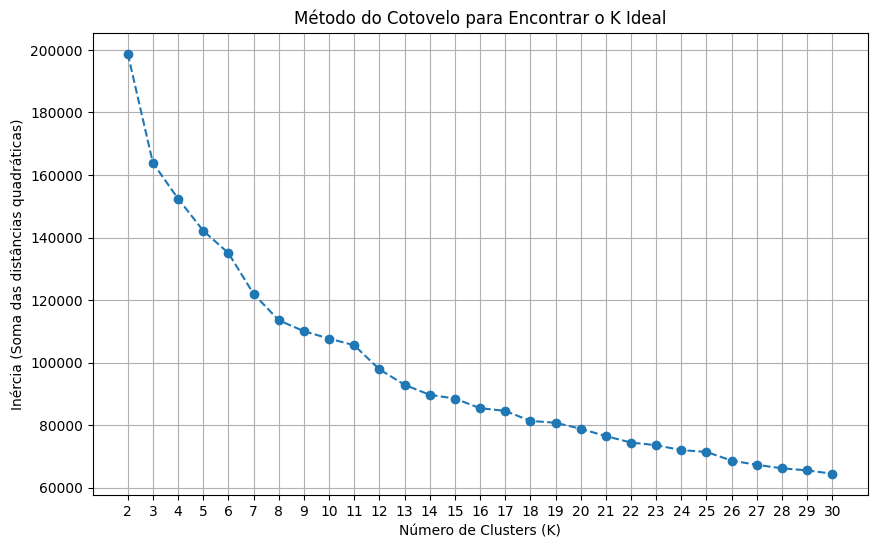

In [51]:
print("\nCalculando a inércia para diferentes valores de K...")
inertia = []
possible_k = range(2, 31) # Testando K de 2 a 30 (K=1 não é útil pra cluster)

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(possible_k, inertia, marker='o', linestyle='--')
plt.title('Método do Cotovelo para Encontrar o K Ideal')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(possible_k)
plt.grid(True)
plt.show()


## *ETAPA 3: Execução dos Modelos de Clusterização*



In [53]:
best_k = 8 # Melhor valor analisando onde se suaviza inicialmente a queda no gráfico (Também foram realizados testes para outros valores)
print(f"\nO valor de K escolhido é: {best_k}")


O valor de K escolhido é: 8


**3.1 - Execução do K-means com o K ideal**

In [54]:
print("Executando K-means...")
kmeans_model = KMeans(n_clusters=best_k, random_state=random_state, n_init='auto')
kmeans_labels = kmeans_model.fit_predict(X_clustering)

Executando K-means...


**3.2 - Execução da Clusterização Hierárquica com linkage 'ward'**

In [55]:
print("Executando Clusterização Hierárquica (ward)...")
hierarchical_ward = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
hierarchical_ward_labels = hierarchical_ward.fit_predict(X_clustering)

Executando Clusterização Hierárquica (ward)...


**3.3 - Execução da Clusterização Hierárquica com linkage 'complete'**

In [56]:
print("Executando Clusterização Hierárquica (complete)...")
hierarchical_complete = AgglomerativeClustering(n_clusters=best_k, linkage='complete')
hierarchical_complete_labels = hierarchical_complete.fit_predict(X_clustering)

Executando Clusterização Hierárquica (complete)...


## *ETAPA 4: Avaliação e Comparação*

Para a tarefa de clusterização, foram testados três algoritmos distintos (K-Means, Hierárquico com linkage 'ward' e Hierárquico com linkage 'complete') com quatro valores diferentes para o número de clusters (K = 8, 16, 18 e 24). A qualidade dos agrupamentos foi avaliada por três métricas diferentes: Silhouette Score, Davies-Bouldin Score e Calinski-Harabasz Score.

In [57]:
print(f"\n--- Calculando Métricas de Avaliação dos Clusters (K={best_k}) ---")

# Dicionários para armazenar as pontuações de cada métrica
silhouette_scores = {}
davies_bouldin_scores = {}
calinski_harabasz_scores = {}

# Dicionário com os resultados da clusterização
clustering_results = {
    "K-means": kmeans_labels,
    "Hierárquico (Linkage='ward')": hierarchical_ward_labels,
    "Hierárquico (Linkage='complete')": hierarchical_complete_labels
}

# Itera sobre cada resultado para calcular, exibir e armazenar as métricas
for model_name, labels in clustering_results.items():
    print(f"\n--- Métricas para: {model_name} ---")

    # Silhouette Score
    sil_score = silhouette_score(X_clustering, labels)
    silhouette_scores[model_name] = sil_score
    print(f"  Silhouette Score         : {sil_score:.4f}")

    # Davies-Bouldin Score
    db_score = davies_bouldin_score(X_clustering, labels)
    davies_bouldin_scores[model_name] = db_score
    print(f"  Davies-Bouldin Score     : {db_score:.4f}")

    # Calinski-Harabasz Score
    ch_score = calinski_harabasz_score(X_clustering, labels)
    calinski_harabasz_scores[model_name] = ch_score
    print(f"  Calinski-Harabasz Score  : {ch_score:.4f}")


--- Calculando Métricas de Avaliação dos Clusters (K=8) ---

--- Métricas para: K-means ---
  Silhouette Score         : 0.1795
  Davies-Bouldin Score     : 1.6446
  Calinski-Harabasz Score  : 396.6355

--- Métricas para: Hierárquico (Linkage='ward') ---
  Silhouette Score         : 0.1527
  Davies-Bouldin Score     : 1.5840
  Calinski-Harabasz Score  : 371.7271

--- Métricas para: Hierárquico (Linkage='complete') ---
  Silhouette Score         : 0.2097
  Davies-Bouldin Score     : 1.4527
  Calinski-Harabasz Score  : 274.4717



*   **Melhor Silhouette Score** (quanto maior, melhor): O valor máximo de **0.2097** foi alcançado pelo modelo **Hierárquico (complete)** com **K=8**. Esta métrica sugere que esta combinação produziu os clusters com o melhor balanço entre coesão interna e separação entre si
*   **Melhor Davies-Bouldin Score** (quanto menor, melhor): O valor mínimo de **1.4527** também foi alcançado pelo modelo **Hierárquico (complete)** com **K=8**. Este resultado reforça a conclusão do Silhouette Score, indicando que este modelo gerou os clusters mais compactos e distintos
*   **Melhor Calinski-Harabasz Score** (quanto maior, melhor): O valor máximo, e com uma margem significativa, foi de **396.64** para o modelo **K-Means** com **K=8**. Esta métrica favorece clusters densos e bem separados, e o K-Means se mostrou superior neste quesito específico

`*`*O ponto mais importante da análise é que as três métricas, independentemente do modelo, apresentaram seus melhores resultados absolutos quando K=8. Isso é uma forte evidência de que, com base nas features de movimento selecionadas, a estrutura natural dos dados se agrupa em 8 super-grupos, mesmo que existam 25 classes de sinais reais. Isso sugere que vários sinais distintos são matematicamente muito similares em seus padrões de movimento.*

`*`*O modelo Hierárquico com linkage 'complete' foi o vencedor em duas das três métricas (Silhouette e Davies-Bouldin), ambas focadas na qualidade estrutural dos clusters (coesão e separação). Isso o torna o candidato mais forte no geral.*

`*`O K-Means, por outro lado, dominou a métrica Calinski-Harabasz. Isso indica que, embora seus clusters possam não ser os mais "bem definidos" geometricamente (segundo o Silhouette), eles são muito densos e a variância entre eles é alta, o que também é uma característica desejável.


**RELATÓRIO DE SCORES PARA OUTROS VALORES DE K**

*Abaixo deixei explícito para qual valor de K cada modelo se saiu melhor*

-----

**Calculando Silhouette Scores (k=8)**

**--- Métricas para: K-means ---**

  Silhouette Score         : 0.1795

  Davies-Bouldin Score     : 1.6446

  Calinski-Harabasz Score  : 396.6355 **MELHOR**

**--- Métricas para: Hierárquico (Linkage='ward') ---**

  Silhouette Score         : 0.1527

  Davies-Bouldin Score     : 1.5840

  Calinski-Harabasz Score  : 371.7271

**--- Métricas para: Hierárquico (Linkage='complete') ---**

  Silhouette Score         : 0.2097 **MELHOR**

  Davies-Bouldin Score     : 1.4527 **MELHOR**

  Calinski-Harabasz Score  : 274.4717

-----

**Calculando Silhouette Scores (k=16)**

**--- Métricas para: K-means ---**

  Silhouette Score         : 0.1934 **MELHOR**

  Davies-Bouldin Score     : 1.5625

  Calinski-Harabasz Score  : 299.6816 **MELHOR**

**--- Métricas para: Hierárquico (Linkage='ward') ---**

  Silhouette Score         : 0.1744

  Davies-Bouldin Score     : 1.6518

  Calinski-Harabasz Score  : 290.7545

**--- Métricas para: Hierárquico (Linkage='complete') ---**

  Silhouette Score         : 0.1692

  Davies-Bouldin Score     : 1.5025 **MELHOR**

  Calinski-Harabasz Score  : 236.0705

-----

**Calculando Silhouette Scores (k=18)**

**--- Métricas para: K-means ---**

  Silhouette Score         : 0.1972 **MELHOR**

  Davies-Bouldin Score     : 1.4802

  Calinski-Harabasz Score  : 284.7139 **MELHOR**

**--- Métricas para: Hierárquico (Linkage='ward') ---**

  Silhouette Score         : 0.1820

  Davies-Bouldin Score     : 1.5207

  Calinski-Harabasz Score  : 277.5335

**--- Métricas para: Hierárquico (Linkage='complete') ---**

  Silhouette Score         : 0.1768

  Davies-Bouldin Score     : 1.4563 **MELHOR**

  Calinski-Harabasz Score  : 241.2306

-----

**Calculando Silhouette Scores (k=24)**

**--- Métricas para: K-means ---**

  Silhouette Score         : 0.1865

  Davies-Bouldin Score     : 1.5063

  Calinski-Harabasz Score  : 251.0841 **MELHOR**

**--- Métricas para: Hierárquico (Linkage='ward') ---**

  Silhouette Score         : 0.1948 **MELHOR**

  Davies-Bouldin Score     : 1.4791 **MELHOR**

  Calinski-Harabasz Score  : 248.1438

**--- Métricas para: Hierárquico (Linkage='complete') ---**

  Silhouette Score         : 0.1675

  Davies-Bouldin Score     : 1.5182

  Calinski-Harabasz Score  : 219.7973

-----

### *Visualização dos Clusters (Uso de PCA)*

O PCA vai "comprimir" todas as features em dois componentes principais que posso usar como eixos X e Y no gráfico

In [58]:
# 1. Redução da dimensionalidade dos dados para 2D com PCA
pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_clustering)

# 2. Criação de um DataFrame com os resultados para facilitar a plotagem
df_plot = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_plot['kmeans_cluster'] = kmeans_labels
df_plot['hierarchical_ward_cluster'] = hierarchical_ward_labels
df_plot['hierarchical_complete_cluster'] = hierarchical_complete_labels

**--- Gráfico para o K-Means (com Centroides) ---**

Fiz o uso de centroides para ter uma maior noção do centro de cada grupo

In [61]:
# Transforma os centroides do K-Means para o mesmo espaço 2D do PCA
centroids_pca = pca.transform(kmeans_model.cluster_centers_)

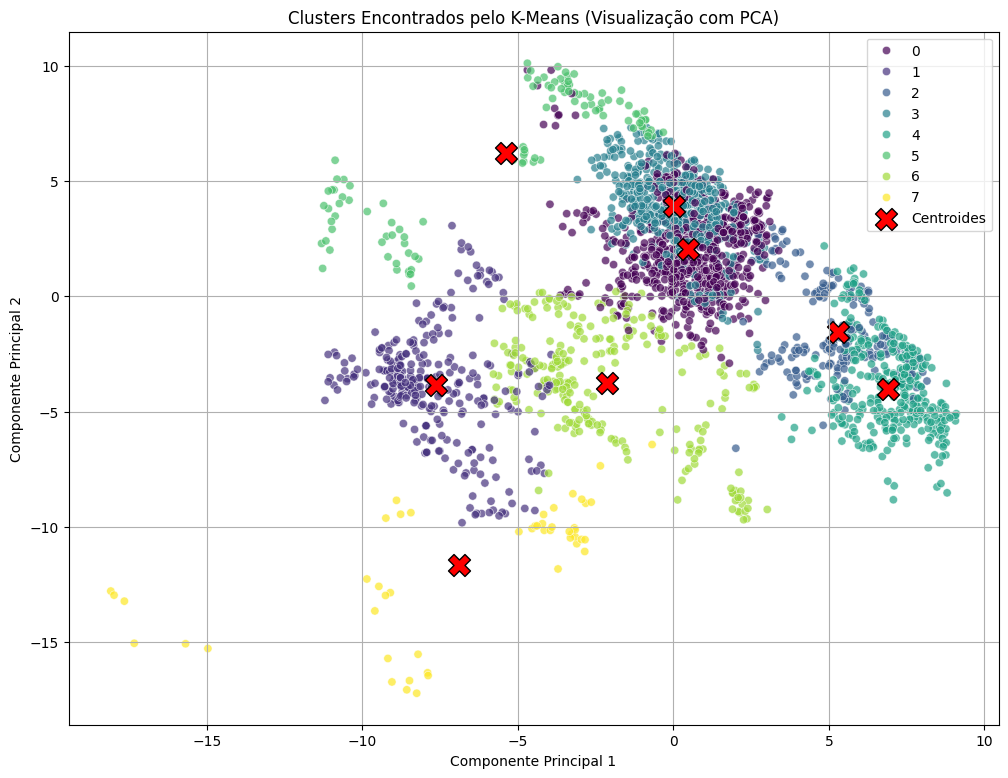

In [63]:
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='kmeans_cluster',
    data=df_plot,
    palette='viridis',
    alpha=0.7,
    legend='full'
)
# Plota os centroides
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    s=250,
    marker='X',
    c='red',
    edgecolor='black',
    label='Centroides'
)
plt.title('Clusters Encontrados pelo K-Means (Visualização com PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

**--- Gráfico para a Clusterização Hierárquica (Ward)**

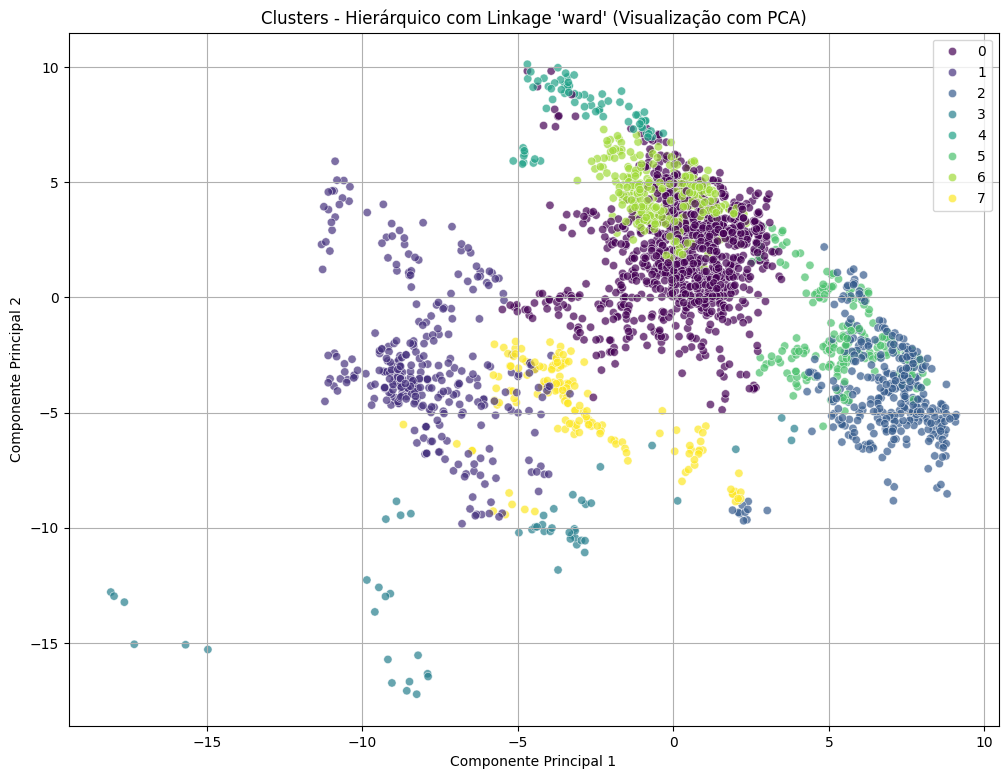

In [64]:
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='hierarchical_ward_cluster',
    data=df_plot,
    palette='viridis',
    alpha=0.7,
    legend='full'
)
plt.title("Clusters - Hierárquico com Linkage 'ward' (Visualização com PCA)")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

**--- Gráfico para a Clusterização Hierárquica (Complete)**

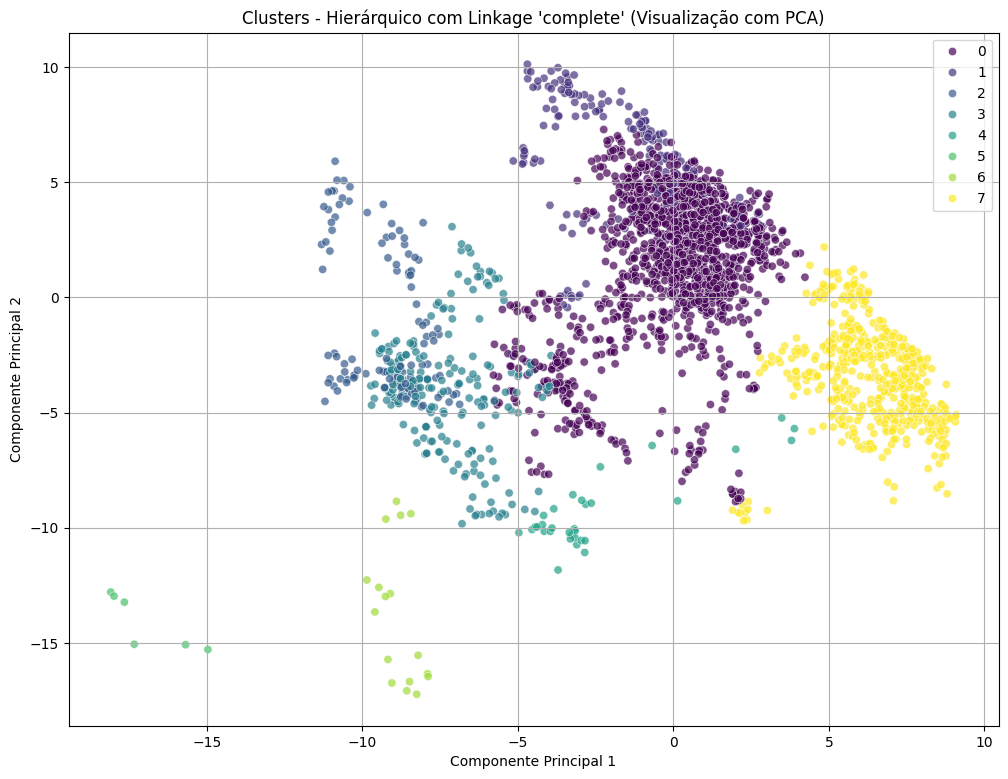

In [65]:
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='hierarchical_complete_cluster',
    data=df_plot,
    palette='viridis',
    alpha=0.7,
    legend='full'
)
plt.title("Clusters - Hierárquico com Linkage 'complete' (Visualização com PCA)")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

### *Comparação final*

In [66]:
print("--- Comparação Final dos Métodos de Clusterização ---")

# Melhor para Silhouette Score - MAIOR é melhor
best_silhouette_model = max(silhouette_scores, key=silhouette_scores.get)
print(f"Melhor Silhouette Score      : '{best_silhouette_model}' (Valor: {silhouette_scores[best_silhouette_model]:.4f})")

# Melhor para Davies-Bouldin Score - MENOR é melhor
best_davies_bouldin_model = min(davies_bouldin_scores, key=davies_bouldin_scores.get)
print(f"Melhor Davies-Bouldin Score  : '{best_davies_bouldin_model}' (Valor: {davies_bouldin_scores[best_davies_bouldin_model]:.4f})")

# Melhor para Calinski-Harabasz Score - MAIOR é melhor
best_calinski_harabasz_model = max(calinski_harabasz_scores, key=calinski_harabasz_scores.get)
print(f"Melhor Calinski-Harabasz Score: '{best_calinski_harabasz_model}' (Valor: {calinski_harabasz_scores[best_calinski_harabasz_model]:.4f})")

--- Comparação Final dos Métodos de Clusterização ---
Melhor Silhouette Score      : 'Hierárquico (Linkage='complete')' (Valor: 0.2097)
Melhor Davies-Bouldin Score  : 'Hierárquico (Linkage='complete')' (Valor: 1.4527)
Melhor Calinski-Harabasz Score: 'K-means' (Valor: 396.6355)


**Análise dos Clusters vs. Rótulos Reais**

Este código faz uma análise de pureza dos clusters, que é uma forma de validação externa. O objetivo é verificar o quão bem os grupos encontrados pelo algoritmo não-supervisionado correspondem as classes reais que nós conhecemos (os 25 sinais).

*--- Análise para o K-Means ---*

In [67]:
# Adiciona os resultados da clusterização ao seu DataFrame original
df_features['cluster_kmeans'] = kmeans_labels

# Usando a função crosstab do pandas para criar uma tabela de contingência para mostrar quantos vídeos de cada sinal cairam em cada cluster
contingency_table = pd.crosstab(df_features['cluster_kmeans'], df_features['sinal'])

# Lista com os 25 sinais do corpus
lista_sinais = [
    "Adição", "Ângulo", "Aluno", "Antropologia", "Apontador", "Apostila",
    "Biologia", "Bolsa de Estudos", "Capítulo", "Classe", "Coerência",
    "Coesão", "Colega", "Conceito", "Contexto", "Curso", "Dicionário",
    "Disciplina", "Ensinar", "Escola", "Estudar", "Filosofia", "Física",
    "Geografia", "História"
]

# Ordena a lista em ordem alfabética para consistência
lista_sinais.sort()

print("--- Legenda de Sinais (Ordem Alfabética) ---")
# Usa enumerate(start=0) para criar uma lista numerada começando do 0
for numero, sinal in enumerate(lista_sinais, start=0):
    print(f"{numero}: {sinal}")

print("--- Tabela de Cruzamento: Cluster vs. Sinal Real ---")
print(f"As linhas representam os Clusters (0 a {best_k}) e as colunas os Sinais.")
print("Os números mostram quantos vídeos de um sinal caíram em um cluster.")

# Usa o display para uma melhor visualização no Colab
display(contingency_table)

--- Legenda de Sinais (Ordem Alfabética) ---
0: Adição
1: Aluno
2: Antropologia
3: Apontador
4: Apostila
5: Biologia
6: Bolsa de Estudos
7: Capítulo
8: Classe
9: Coerência
10: Coesão
11: Colega
12: Conceito
13: Contexto
14: Curso
15: Dicionário
16: Disciplina
17: Ensinar
18: Escola
19: Estudar
20: Filosofia
21: Física
22: Geografia
23: História
24: Ângulo
--- Tabela de Cruzamento: Cluster vs. Sinal Real ---
As linhas representam os Clusters (0 a 8) e as colunas os Sinais.
Os números mostram quantos vídeos de um sinal caíram em um cluster.


sinal,Adicao,Aluno,Angulo,Antropologia,Apontador,Apostila,Biologia,Bolsa de Estudos,Capitulo,Classe,...,Curso,Dicionario,Disciplina,Ensinar,Escola,Estudar,Filosofia,Fisica,Geografia,Historia
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,16,0,30,0,37,41,0,36,54,48,...,37,43,28,20,46,60,0,0,0,0
1,20,20,20,20,20,18,10,20,20,20,...,0,20,20,0,10,0,0,0,0,0
2,0,70,0,60,0,3,0,0,0,0,...,0,7,0,0,0,0,0,0,0,0
3,54,0,40,0,30,26,0,27,16,29,...,53,20,40,70,21,30,0,0,0,0
4,0,0,0,0,0,0,60,0,0,0,...,0,0,0,0,0,0,60,79,60,69
5,0,0,0,10,0,0,20,0,0,0,...,0,0,0,0,0,0,20,10,20,20
6,11,11,10,10,13,12,10,16,10,3,...,10,10,12,10,23,10,10,0,10,10
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,11,10,1


*--- Análise para o Hierárquico (Ward) ---*

In [68]:
df_features['cluster_ward'] = hierarchical_ward_labels
contingency_table_ward = pd.crosstab(df_features['cluster_ward'], df_features['sinal'])
print("\n--- Tabela de Cruzamento para Hierárquico (Ward) ---")
display(contingency_table_ward)


--- Tabela de Cruzamento para Hierárquico (Ward) ---


sinal,Adicao,Aluno,Angulo,Antropologia,Apontador,Apostila,Biologia,Bolsa de Estudos,Capitulo,Classe,...,Curso,Dicionario,Disciplina,Ensinar,Escola,Estudar,Filosofia,Fisica,Geografia,Historia
cluster_ward,,,,,,,,,,,,,,,,,,,,,
0,40,0,30,0,50,50,0,40,60,70,...,76,50,60,70,60,70,0,0,0,0
1,20,10,20,20,20,20,20,20,20,20,...,0,20,20,0,10,0,10,0,10,10
2,0,0,0,0,0,0,60,0,0,0,...,0,0,0,0,0,0,70,76,60,69
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,14,10,1
4,0,0,0,10,0,0,10,0,0,0,...,0,0,0,0,0,0,10,10,10,10
5,0,70,0,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,31,0,40,0,20,20,0,29,10,10,...,24,20,20,30,20,30,0,0,0,0
7,10,21,10,10,10,10,10,10,10,0,...,0,10,0,0,10,0,0,0,10,10


*--- Análise para o Hierárquico (Complete) ---*

In [69]:
df_features['cluster_complete'] = hierarchical_complete_labels
contingency_table_complete = pd.crosstab(df_features['cluster_complete'], df_features['sinal'])
print("\n--- Tabela de Cruzamento para Hierárquico (Complete) ---")
display(contingency_table_complete)


--- Tabela de Cruzamento para Hierárquico (Complete) ---


sinal,Adicao,Aluno,Angulo,Antropologia,Apontador,Apostila,Biologia,Bolsa de Estudos,Capitulo,Classe,...,Curso,Dicionario,Disciplina,Ensinar,Escola,Estudar,Filosofia,Fisica,Geografia,Historia
cluster_complete,,,,,,,,,,,,,,,,,,,,,
0,71,29,80,10,60,80,10,79,80,70,...,100,68,80,90,90,100,0,0,10,10
1,10,0,0,10,20,0,10,0,0,10,...,0,12,0,10,0,0,10,10,10,10
2,10,10,10,10,0,0,10,0,0,10,...,0,10,10,0,0,0,10,0,10,10
3,10,10,10,10,20,20,10,20,20,10,...,0,10,10,0,10,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,1,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,4,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,5,0
7,0,52,0,60,0,0,60,0,0,0,...,0,0,0,0,0,0,70,76,60,69
